Versions:
* v1: one full cycle. Not yet multiple cycles implemented
* v2: MORDM cycle into IO-function
    * Can be used for MORDM validation
* v3: restructure into MORDM function
* v4: mpmordm iterative way - Finished
* v5: 
    * Micromodel between iterations
    * Distance table based on OSRM (not used in model, only for distances uncertainty
    * OSRM is not yet integrated in full process. just done once
* v6:
    * start: real distance matrix
    * then: real input data FLs
* v7: Verified that the mordm algorithmic function produces the same result as the decoupled version in MORDM v9 Model Testing
* v8: Nepal Data Full Run
* v9: Fixed bug: csv index numbers are now correct
* v10: Fixed bug: Changing information works correctly (typo in function, now checked)
* v11: New model (v9) and update uncertainty ranges for DSRFL and DSRDP
* v12: Increased effect uncertainty reduction


TODO inputdata: 
* parametrisation sigmoid and linear function

TODO model:


TODO:
* Priority: add singleextra location to non-dominated with highest information yield
* Priority: change info based on locations
* non-random disruption - for after MT?
* non-random uncertainty changes - for after MT?

TODO code:
* Clean foldernames and stuff. same foldername and subfolders based on case. casename/subfolders

# Imports

In [1]:
# Standard imports & printing versions
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Own Model import
from lib.fl_model_v10 import *
# import lib.fl_model_v5 as flm

# for natural sorting
import re

#for nondominated sorting
import lib.pareto as pareto
# from lib.list_imports import find_loaded_modules

# for parallel plotting
from lib.parallel_plotting import plot_optimal

# For checking ema running time
import time

import ema_workbench as ema
from ema_workbench.em_framework import (Policy, IntegerParameter, Constant,
                                        RealParameter, ScalarOutcome,
                                        perform_experiments, Model)
from ema_workbench import ema_logging
# from ema_workbench.em_framework.

ema_logging.log_to_stderr(ema_logging.INFO)

import sys

# for routing table:
import osrm

# For creation of disruption landscape: use vincenty for distance:
import geopy
from geopy.distance import great_circle

# for Plotting of Nepal
import folium

C:\Users\timro\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
# %load https://gist.github.com/TRomijn/d9d28ba7b7d5eeac1deea5a26dd326b2/raw/loaded_modules.py

'''
original author: kinverarity1

List loaded modules and packages, and show their version numbers
and/or Git repository's HEAD commit SHA.


Changes:
Minor changes to make compatible with Python 3
'''
# Standard library modules
import types
import os

# Third-party packages
import git      # GitPython


def module_path(mod):
    '''Returns path to the file that module *mod* comes from.
    If it doesn't come from a file, return None.'''
    if hasattr(mod, '__file__'):
        return os.path.abspath(os.path.dirname(mod.__file__))
    else:
        return None

    
def from_git_repo(mod):
    '''Does the module *mod* reside in a Git repository?'''
    path = module_path(mod)
    if path:
        try:
            repo = git.Repo(path)
        except:
            return False
        else:
            return True
    else:
        return False

    
def git_path_sha(mod, slice=slice(0, 8, 1)):
    '''Return SHA hash for the HEAD commit for the repository
    that the module *mod* resides in.'''
    repo = git.Repo(module_path(mod))
    return repo.git_dir, repo.head.commit.hexsha[:8]


def module_version(mod):
    '''Return version string for module *mod*, or nothing if
    it doesn't have a "version" or "__version__" attribute.'''
    version = []
    if hasattr(mod, '__dict__'):
        keys = []
        for key in mod.__dict__.keys():
            if key.lower() == 'version' or key.lower() == '__version__':
                v = mod.__dict__[key]
                if isinstance(v, str):
                    version.append(v)
        if keys:
            print (mod, keys)
    if version:
        return ', '.join(version)
    else:
        return ''

    
def find_loaded_modules(only_versioned_modules=True):
    '''Return list of loaded modules for which there is a version
    number or a Git repository commit SHA.
    
    Return a list of *(name, version, path_to_git_repo, git_head_sha)*,
    which has an HTML property for pretty display in IPython Notebooks.
        
    '''
    def list_of_lists_to_HTML(lists, header_row=None):
        '''Convert a list of a list of strings to a HTML table.'''
        s = '<table>'
        if header_row:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<th>%s</th>' % item for item in header_row])
            s += '\n\t</tr>'
        for inner_list in lists:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<td>%s</td>' % item for item in inner_list])
            s += '\n\t</tr>'
        s += '\n</table>'
        return s
    
    class LoadedModules(list):
        '''Very simple wrapper for a list of lists of strings, with an attribute
        for display in IPython Notebooks.'''
        def __init__(self, *args, **kwargs):
            list.__init__(self, *args, **kwargs)
            
        @property
        def HTML(self):
            from IPython.display import HTML
            return HTML(
                    list_of_lists_to_HTML(
                            self, header_row=['Name', 'Version', 'Path', 'SHA']))
                    
    objs = LoadedModules()
    for i, mod in enumerate(globals().values()):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__'):
                name = mod.__name__
            else:
                name = ''
            
            if from_git_repo(mod):
                path, sha = git_path_sha(mod)
            else:
                path = ''
                sha = ''
            
            version = module_version(mod)
            
            if only_versioned_modules:
                flag = version or (path and sha)
            else:
                flag = True
            
            if flag:
                objs.append([mod.__name__, version, path, sha])
    objs.sort(key=lambda r: r[0])
    return objs


    
    

In [3]:
find_loaded_modules().HTML

Name,Version,Path,SHA
ema_workbench,1.1.3,,
folium,0.5.0,,
geopy,1.13.0,,
git,2.1.9,,
json,2.0.9,,
lib.pareto,1.1.1-3,,
numpy,1.14.2,,
osrm,0.11.1,,
pandas,0.23.0,,
re,2.2.1,,


# Set Meta Data

In [4]:
case = "Nepal"
output_folder = "Simulation-results-no-unc-red"
# output_folder = "Output_testing5"

# Load Prepared Data

In [5]:
DPs = pd.read_csv("{}/Prepared Input Data/DPs.csv".format(case))
DPs.columns

Index(['name', 'population', 'latitude', 'longitude'], dtype='object')

In [6]:
FLs = pd.read_csv("{}/Prepared Input Data/FLs.csv".format(case))
FLs.columns

Index(['Name', 'Lat', 'Lon'], dtype='object')

In [7]:
SPs = pd.read_csv("{}/Prepared Input Data/SPs.csv".format(case))
SPs.columns

Index(['name', 'latitude_deg', 'longitude_deg'], dtype='object')

In [8]:
# Routing Table for changing information based on distance
# time_matrix
time_matrix = pd.read_csv("{}/Prepared Input Data/routing_table.csv".format(case))
nodes = time_matrix.columns
time_matrix.index = nodes

## Prepare Data for model input

### Global: Fixed certain data

In [9]:
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(DPs['latitude'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(DPs['longitude'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(SPs['latitude_deg'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(SPs['longitude_deg'])}

# Facility locations
FLX = {"FLX{}".format(i): x for i,x in enumerate(FLs['Lon'])}
FLY = {"FLY{}".format(i): y for i,y in enumerate(FLs['Lat'])}

# Population demand points
DPpop = {"DPpop{}".format(i): pop for i,pop in enumerate(DPs['population'])}

### Global: Fixed uncertain data

In [10]:
print("Warning: use the right table. difference for FL range in different csv files")

In [11]:
global_fixed_unc = pd.read_csv("{}/Prepared Input Data/fixed_uncertainties.csv".format(case)).set_index('var')

### Variable Uncertain Data: generate random for now:
DFs becomes a global. can be accessed by using its label

In [12]:
# # TODO: Base real values on Nepal earthquake
# # DSR = Disruption
# DSRDP = {"DSRDP{}".format(i): random.uniform (1, 2) for i in range(len(DPX))}
# DSRFL = {"DSRFL{}".format(i): random.uniform (1, 2) for i in range(len(FLX))}


#### Use radial function to determine disruption value

In [13]:
epicentre_name = "RealLocation"

In [14]:
disruptionsFLs = np.loadtxt(
    'Nepal/Prepared Input Data/DisruptionFL{}.txt'.format(epicentre_name))
disruptionsDPs = np.loadtxt(
    'Nepal/Prepared Input Data/DisruptionDP{}.txt'.format(epicentre_name))

In [15]:
# Base real values on Nepal earthquake
# DSR is abbreviation for Disruption

DSRDP = {"DSRDP{}".format(i): disruptionsDPs[i] for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): disruptionsFLs[i] for i in range(len(FLX))}

### Sth

In [16]:
# label each branch. start with:
start_label = "p0n0"
# Each branch has a separate perception of what the data is.
# A dictionary can keep track of data for each branch, linked via label
global_dfs_var_unc_data = {}

In [17]:
global_dfs_var_unc_data [start_label] = pd.DataFrame.from_dict({**DSRDP, **DSRFL}, orient='index')

In [18]:
global_dfs_var_unc_data [start_label].head(1)

,0
DSRDP0,1.520303


In [19]:
# create upper and lower bound

global_dfs_var_unc_data[start_label] = global_dfs_var_unc_data[
    start_label].rename(columns={0: "actual"})

global_dfs_var_unc_data[start_label]['lower'] = 1
global_dfs_var_unc_data[start_label]['upper'] = 2
global_dfs_var_unc_data[start_label]['best_estimate'] = (
    global_dfs_var_unc_data[start_label]['upper'] +
    global_dfs_var_unc_data[start_label]['lower']) / 2
# global_dfs_var_unc_data[start_label][
#     'difference'] = global_dfs_var_unc_data[start_label]['best_estimate'] - global_dfs_var_unc_data[start_label]['actual']
global_dfs_var_unc_data[start_label].head()

,actual,lower,upper,best_estimate
DSRDP0,1.520303,1,2,1.5
DSRDP1,1.290710,1,2,1.5
DSRDP2,1.520151,1,2,1.5
DSRDP3,1.900000,1,2,1.5
DSRDP4,1.494693,1,2,1.5


In [20]:
global_dfs_var_unc_data.keys()

dict_keys(['p0n0'])

### Other Globals:
- Create Starting situation policies:
- List of all Models

# MORDM

## Helper functions

In [21]:
def create_policies(FL_dict, print_pols=False):
    """
    Takes the current network of Facility Locations and returns all possible policies for one added FL.
    
    Input: current option (Dict of FLs)
    Output: List of options (Dicts of FLs)
    
    Printing module not completely reliable. doesnt print whats actually in thereTODO
    """

    def natural_key(string_):
        return [
            int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)
        ]

    # All FL names
    FL_keys = sorted(FL_dict.keys(), key=natural_key)
    # All FL values indicating whether operational
    FL_values = [FL_dict[key] for key in FL_keys]

    i_operational_fls = i_FL_op = [
        i for i, x in enumerate(FL_values) if x == 1
    ]

    # Create list of policies
    pols = np.identity(len(FL_keys))
    # Set already operational facilities to operational
    pols[:, i_operational_fls] = 1

    #Delete policies where no new FLs are placed
    new_n_operational_fls = sum(FL_values) + 1
    pols = pols[pols.sum(axis=1) == new_n_operational_fls]

    # Return a list of dictionaries
    policy_list = []
    for pol in pols:
        policy_list.append({key: value for key, value in zip(FL_keys, pol)})

    if print_pols == True:
        print("total policies:", len(policy_list))
        for n, i in enumerate(policy_list):
            for v in i.values():
                print(int(v), end='')
            print(" <- policy {}".format(n))

    return policy_list


def calculate_signalNoise(data, obj):
    '''
    data : 1d array, the values of an outcome indicator for a policy
    obj  : the objective corresponding to an outcome indicator, 1 or -1
    '''
    if obj == -1:  #MINIMIZE
        score = (np.mean(data) + 1) * (
            np.std(data) + 1
        )  #to avoid division by zero if the std. deviation is zero, we can add 1.
    elif obj == 1:  #MAXIMIZE
        score = (np.mean(data) + 1) / (np.std(data) + 1)
    return score


def calculate_maxregret(data, obj):
    '''
    data : a list of 1d arrays whose shape is no_policies x no_scenarios
    obj : -1 or 1, the objective 
    '''
    data = np.array(data)
    if obj == 1:  #MAXIMIZE
        #find the best case in each scenario, therefore use the max function of numpy on the axis of policies
        zero_regrets = np.max(data, axis=0)
    elif obj == -1:  #MINIMIZE
        zero_regrets = np.min(data, axis=0)

    #determine the regret values for eaxh policy in each scenario
    regrets = [
        abs(np.subtract(data[p], zero_regrets)) for p in range(data.shape[0])
    ]

    max_regrets = np.max(regrets, axis=1)

    return max_regrets


## Main

MORDM function should be defined within main script, because it uses global files

In [22]:
"""
Many-Objective Robust Decision-Making Algorithm
Specifically implemented to be consistent with the FL model
"""

def MORDM(current=None,
          current_period=None,
          trace_label=None,
          n_scenarios=100,
          table_dir="prespecify routing table.csv",
          saving_dir="prespecify this dir/",
          additional_info=None,
          show_MORDM_graphics=False,
          show_model_graphics=False):
    """
    current: indexes of current operational locations
    trace_label: label of input node
    fixed_data: 
    var_data: df of variable data for each 
    max_depth: maximum number of total FLS
    """

    if show_MORDM_graphics == True:
        raise NotImplementedError("""visualisations are not implemented (yet). 
            Not sure yet if impementing graphics in MPMORDM is usefull for every period """
                                  )

    #Start Many Objective Optimisation
    #best estimate values
    best_estimate_disruptions = {
        i: be
        for be, i in zip(global_dfs_var_unc_data[trace_label]['best_estimate'],
                         global_dfs_var_unc_data[trace_label].index)
    }
    
    # create list of already operational FLS
    current_fls = [fl for fl in current.keys() if current[fl] == 1]
    # Create new policies
    optional_policies = create_policies(current, print_pols=False)
    # Create list of new optional FLS, without the already operational FLS
    optional_fls = [[key for key in dic.keys() if dic[key] == 1 and key not in current_fls] for dic in optional_policies]
    # Flatten and take only integers
    optional_fls = np.array([int(item[3:]) for sublist in optional_fls for item in sublist])
    # Check
    if len(optional_fls) != len (optional_policies):
        print("Warning2! Something not right")

    #evaluate all policies
    best_est_results_opt_pols = []
    for policy in optional_policies:
        best_est_results_opt_pols.append(
            FL_model(
#                 unit_opening_costs=global_fixed_unc.loc["unit_opening_costs",
#                                                         "best_estimate"],
                unit_transport_cost=global_fixed_unc.loc["unit_transport_cost",
                                                         "best_estimate"],
#                 FL_operations_cost=global_fixed_unc.loc["FL_operations_cost",
#                                                         "best_estimate"],
                graphical_representation=show_model_graphics,
                FL_range=global_fixed_unc.loc["FL_range",
                                              "best_estimate"],  # km? --> m
                dist_method="from_table",
                table_dir=table_dir,
                demand_per_affected=global_fixed_unc.loc[
                    "demand_per_affected", "best_estimate"],  #km/u? --> m/s
                # fixed certain
                **SPX,
                **SPY,
                **DPX,
                **DPY,
                **FLX,
                **FLY,
                **DPpop,
                # specific
                **policy,
                **best_estimate_disruptions))

    if len(best_est_results_opt_pols) == 0:
        raise ValueError(
            "No results found in many-objective optimisation (before constraint)"
        )
    #constraint 1:
    #Filter out those where not all operational FLs provide supplies to DPs


#     best_est_results_opt_pols2 = [pol for pol in best_est_results_opt_pols if pol[-1] == True]

# outcome indicators, as internally used by the model
    oois = [
        'total_costs', 'nr_uncovered_DPs', 'total_uncovered_demand',
        'max_distr_time'
    ]
    # Put outcomes in DF
    df_best_est_results_opt_pols = pd.DataFrame(
        np.asarray(best_est_results_opt_pols)[:, :5],
        columns=oois + ["constraint1"])

    # Filter out based on constraint1
    df_best_est_results_opt_pols = df_best_est_results_opt_pols[
        df_best_est_results_opt_pols.constraint1 == 1]
    # remove constraint label
    df_best_est_results_opt_pols = df_best_est_results_opt_pols[oois]

    # print("move this somewhere else TODO")
    # print("XXX", df_best_est_results_opt_pols.shape)
    if df_best_est_results_opt_pols.shape[0] == 0:
        raise ValueError(
            "No results found in many-objective optimisation that satisfy constraints \n probably wrong FL_range"
        )

    #nondominated sorting
    nondominated_BE_policy_results = np.array(
        pareto.eps_sort(
            [list(df_best_est_results_opt_pols.itertuples(index=True))],
            [1, 2, 3, 4], [1e-9, 1e-9, 1e-9, 1e-9]))


    #put nondominated policies in array
    nondom_i = [int(a[0]) for a in nondominated_BE_policy_results]
    nondominated_BE_policies = np.array(optional_policies)[nondom_i]
    nondom_fls = optional_fls[nondom_i]
    
    df_nondom_BE_pols = pd.DataFrame(
        nondominated_BE_policy_results, columns=["i"] + oois).set_index("i")
    # Give FL numbers as correct index
    df_nondom_BE_pols.index = nondom_fls
    
    df_nondom_BE_pols.to_csv(
        saving_dir + "nondom_BE_pols{}.csv".format(trace_label))

    #End Many Objective Optimisation
    #Start Robustness analysis

    EMA_model_dict[trace_label] = Model("flmodel{}".format(trace_label),
                                        FL_model)

    EMA_model_dict[trace_label].locations = [
        Constant("DPX{}".format(i), x)
        for i, x in zip(DPs.index, DPs['longitude'])
    ] + [
        Constant("DPY{}".format(i), y)
        for i, y in zip(DPs.index, DPs['latitude'])
    ] + [
        Constant("SPX{}".format(i), x)
        for i, x in zip(SPs.index, SPs['longitude_deg'])
    ] + [
        Constant("SPY{}".format(i), y)
        for i, y in zip(SPs.index, SPs['latitude_deg'])
    ] + [
        Constant("FLX{}".format(i), x) for i, x in zip(FLs.index, FLs['Lon'])
    ] + [
        Constant("FLY{}".format(i), y) for i, y in zip(FLs.index, FLs['Lat'])
    ]

    # model.locations_uncertain =   [
    #     RealParameter("FLX{}".format(i), DPs['Longitude (DD)'].min(), DPs['Longitude (DD)'].max()) for i in range(nr_of_FLs)
    # ] + [RealParameter("FLY{}".format(i), DPs['Latitude (DD)'].min(), DPs['Latitude (DD)'].max()) for i in range(nr_of_FLs)]

    EMA_model_dict[trace_label].constants = [
        Constant('graphical_representation', False),
        Constant('dist_method', 'from_table'),
        Constant('Error_Test', 1),  # this doesn't do anything. 
        #list of other constants
        Constant('table_dir', table_dir)
    ] + EMA_model_dict[trace_label].locations + [  # population DPs
        Constant("DPpop{}".format(i), pop)
        for i, pop in zip(DPs.index, DPs['population'])
    ]

    # Reachability of Demand Points and Facility Locations can be disrupted
    # Disruption also determines demand (disr-1)*pop
    EMA_model_dict[trace_label].disruptions = [
        RealParameter(i, l, u) for i, l, u in zip(global_dfs_var_unc_data[
            trace_label].index, global_dfs_var_unc_data[trace_label][
                'lower'], global_dfs_var_unc_data[trace_label]['upper'])
    ]

    EMA_model_dict[trace_label].uncertainties = [
        RealParameter(i, l, u)
        for i, l, u in zip(global_fixed_unc.index, global_fixed_unc.lower,
                           global_fixed_unc.upper)
    ] + EMA_model_dict[trace_label].disruptions  #+ model.locations_uncertain

    EMA_model_dict[trace_label].outcomes = [
        ScalarOutcome("total_costs", kind=ScalarOutcome.MINIMIZE),
        ScalarOutcome("nr_uncovered_DPs", kind=ScalarOutcome.MINIMIZE),
        ScalarOutcome("total_uncovered_demand", kind=ScalarOutcome.MINIMIZE),
        ScalarOutcome(
            "max_distr_time",
            kind=ScalarOutcome.MINIMIZE,
        )
    ]

    if [o.name for o in EMA_model_dict[trace_label].outcomes] != oois:
        print("Watch out! Oois and model outcome names are not similar!")

    nondominated_BE_policies_EMA = []
    for name, pol in zip(nondom_i, nondominated_BE_policies):
        nondominated_BE_policies_EMA.append(Policy("{}".format(name), **pol))

    time1 = time.time()
    all_scen_results_nondom_pols = perform_experiments(
        EMA_model_dict[trace_label], n_scenarios, nondominated_BE_policies_EMA)
    time2 = time.time()
    print("Total time:{}".format(time2 - time1), "\n",
          "time per run = {}".format(
              (time2 - time1) /
              (n_scenarios * len(nondominated_BE_policies_EMA))))

    ema.save_results(all_scen_results_nondom_pols,
                     saving_dir + "{}.tar.gz".format(trace_label))
    experiments, outcomes = all_scen_results_nondom_pols

    sigN_results = []

    for policy in nondominated_BE_policies_EMA:
        #filter the outcome values corresponding to each policy using a logical index
        logical_index = experiments['policy'] == policy.name
        # If ever something goes wrong here, probably add: int() to policy.name
        pol_outcomes = {
            key: outcomes[key][logical_index]
            for key in outcomes.keys()
        }
        temp_result = {}
        for ooi in EMA_model_dict[trace_label].outcomes:
            temp_result[ooi.name] = calculate_signalNoise(
                pol_outcomes[ooi.name], ooi.kind)
        sigN_results.append(temp_result)

    df_sigN = pd.DataFrame(
        sigN_results, index=[pol.name for pol in nondominated_BE_policies_EMA])

    reg_results = {}
    # we need to iterate over the outcomes differently now,
    #because the maximum egret calculation requires the outcome values for all policies
    for ooi in EMA_model_dict[trace_label].outcomes:
        data = []
        for policy in nondominated_BE_policies_EMA:
            logical_index = experiments['policy'] == policy.name
            # If ever something goes wrong here, add int() to policy.name
            data.append(outcomes[ooi.name][logical_index])
        reg_results[ooi.name] = calculate_maxregret(data, ooi.kind)
    df_regret = pd.DataFrame.from_dict(
        reg_results,
        orient='columns',
    )
    df_regret.index = [pol.name for pol in nondominated_BE_policies_EMA]

    all_robustness_scores = pd.merge(
        df_regret,
        df_sigN,
        left_index=True,
        right_index=True,
        suffixes=("_regret", "_sigN"))

    robust_nondominated_policies = pareto.eps_sort(
        [list(all_robustness_scores.itertuples(index=True))],
        [i + 1 for i in range(all_robustness_scores.shape[1])],
        [1e-9] * all_robustness_scores.shape[1])

    if len(robust_nondominated_policies) == 0:
        print("something went wrong")
    elif len(robust_nondominated_policies) == 1:
        print("no branching, only a single nondominated robust location")
        temp_cols = ["pol_i"] + list(all_robustness_scores.columns)

        df_rob_nondom_pols = pd.DataFrame(
            robust_nondominated_policies, columns=temp_cols).set_index("pol_i")
    #     print(robust_nondominated_policies)
    else:
        temp_cols = ["pol_i"] + list(all_robustness_scores.columns)
        df_rob_nondom_pols = pd.DataFrame(
            robust_nondominated_policies, columns=temp_cols).set_index("pol_i")

    nondom_rob_fls = optional_fls[list(df_rob_nondom_pols.index.astype(int))]
    
    rob_nondom_i = [int(i) for i in df_rob_nondom_pols.index]
    
    df_rob_nondom_pols.index = nondom_rob_fls
    df_rob_nondom_pols.to_csv(
        saving_dir + "nondom_rob_pols{}.csv".format(trace_label))


    return np.array(optional_policies)[rob_nondom_i]

# Full cycle

In [23]:
global_dfs_var_unc_data.keys()

dict_keys(['p0n0'])

#### define and plot sigmoid and linear funtion

In [24]:

def linear(x, dist_max, depth=0.1, height=0.5, plotting=False):
    """
    dist: max distance that yields new info
    height: max percentage of new info
    """
    if plotting == False:
        return max(min(height - (height/dist_max) * x,height),depth)
    if plotting == True:
        return [max(min(height - ((height-depth)/(dist_max)) * y,height),depth) for y in x]


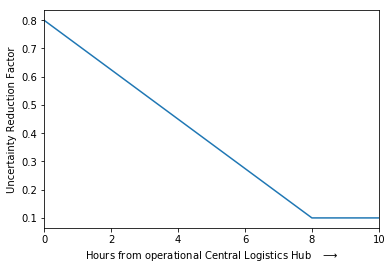

In [25]:
x=np.linspace(-1,10,100)
plt.plot(x,linear(x, 8,height=0.8,plotting=True))
plt.xlabel(r'Hours from operational Central Logistics Hub$\quad\longrightarrow$')
plt.ylabel("Uncertainty Reduction Factor")
plt.xlim((0,10))
plt.show()
# print("make sure that all units etc. are right: km,s,hours,etc,etc")
# plt.savefig("Linear_far")

#### Model Uncertainty Reduction

In [26]:
def new_est_low_up(row, fl_n, method="linear", lin_max_dist = 8):
    """
    method: linear or sigmoid
    Verified"""
    row_label = row.name[3:]
    fl_label = "FL{}".format(fl_n)
    dist = time_matrix.loc[fl_label, row_label]
    if method == "linear":
        # The only uncertainty included here is because of time. Each timestep 10% of info is reduced
        unc_red = 0.0
#         print(unc_red)
    if method == "sigmoid":

        unc_red == sigmoid (dist/3600)
    be_new = row['best_estimate'] + (row['actual']-row['best_estimate'])* unc_red
    low_new = be_new - 0.5 * (row['upper']-row['lower']) * (1-unc_red)
    up_new = be_new + 0.5 * (row['upper']-row['lower']) * (1-unc_red)
    return low_new, be_new, up_new

In [27]:
def change_decision_based_uncertainty(df, fls_dict):
    """
    input: current df, integer operational FLs
    returns changed dataframe
    """ 
    fls = [int(key[3:]) for key,val in fls_dict.items() if val == 1]
    
    df2 = df.copy(deep=True)
    for fl in fls:
        print(fl,type(fl))
        
    for fl in fls:
        df2['lower'], df2['best_estimate'], df2['upper'] = zip(
            *df2.apply(lambda row: new_est_low_up(row, fl), axis=1))
    return df2


# df3 = change_decision_based_uncertainty(df_test, [2, 3])

In [28]:
time.time()

1533215207.3530483

In [29]:
time.time()

1533215207.9463022

In [30]:
periods = 4  # 1 location per period -> locations = periods

global_node_counter = 0

start_situation = {key: 0 for key in FLs.Name}
global_policy_tree = {start_label: start_situation}
global_label_tree = {
    "p{}".format(p, global_node_counter): []
    if p != 0 else ["{}".format(start_label)]
    for p in range(periods + 1)
}

EMA_model_dict = {}  # XX somewhere else: global
print("starting label:", start_label)
time_start = time.time()
print("starting time:",time_start)

for p in range(periods):
    for node_i, node in enumerate(list(global_label_tree["p{}".format(p)])):
        #         print("|", p, node)
        if p < periods:
            print("Do mordm, in period:", p, "label:", node, "policy:",
                  global_policy_tree[node])
            #             new_pols = ["a", "b", "c"]
            new_pols = MORDM(
                current=global_policy_tree[node],
                n_scenarios=500,
                trace_label=node,
                table_dir="{}/Prepared Input Data/routing_table.csv".format(case),
                saving_dir="{}/{}/".format(case, output_folder))
            for new_pol in new_pols:
                # Create new label
                global_node_counter += 1
                new_label = node + "p{}n{}".format(p + 1, global_node_counter)
                print("result:|||", new_label)
                # Create new branch
                global_label_tree["p{}".format(p + 1)].append(new_label)
                # add new policy
                global_policy_tree[new_label] = new_pol
                # change information based on policy
                #TODO not implemented yet
                #                 global_dfs_var_unc_data[new_label] = global_dfs_var_unc_data[start_label]
                print(new_pol)
                #change uncertainty based on new policy implementations
                global_dfs_var_unc_data[
                    new_label] = change_decision_based_uncertainty(
                        global_dfs_var_unc_data[node], new_pol)

        else:
            print(p, "if you see this, sth went wrong.")

            

time_end = time.time()
print("Ending_time:",time_end)
print("Total seconds:",time_end - time_start)

starting label: p0n0
starting time: 1533215208.7472441
Do mordm, in period: 0 label: p0n0 policy: {'FLO0': 0, 'FLO1': 0, 'FLO2': 0, 'FLO3': 0, 'FLO4': 0, 'FLO5': 0, 'FLO6': 0, 'FLO7': 0, 'FLO8': 0, 'FLO9': 0, 'FLO10': 0, 'FLO11': 0, 'FLO12': 0, 'FLO13': 0, 'FLO14': 0, 'FLO15': 0, 'FLO16': 0, 'FLO17': 0, 'FLO18': 0, 'FLO19': 0}


[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:45.56891417503357 
 time per run = 0.011392228543758392


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0.tar.gz


result:||| p0n0p1n1
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
result:||| p0n0p1n2
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
result:||| p0n0p1n3
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
11 <class 'int'>
result:||| p0n0p1n4
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:46.904152393341064 
 time per run = 0.011726038098335266


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1.tar.gz


result:||| p0n0p1n1p2n7
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
result:||| p0n0p1n1p2n8
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
result:||| p0n0p1n1p2n9
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.494683265686035 
 time per run = 0.011831561088562011


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2.tar.gz


result:||| p0n0p1n2p2n15
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
result:||| p0n0p1n2p2n16
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
result:||| p0n0p1n2p2n17
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
15 <class 'int'>
result:||| p0n0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:36.00838851928711 
 time per run = 0.012002796173095702


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3.tar.gz


result:||| p0n0p1n3p2n19
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n20
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n21
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
11 <class 'int'>
result:||| p0

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:46.89400935173035 
 time per run = 0.011723502337932587


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4.tar.gz


result:||| p0n0p1n4p2n25
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
13 <class 'int'>
result:||| p0

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:47.70836639404297 
 time per run = 0.011927091598510742


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5.tar.gz


result:||| p0n0p1n5p2n32
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
14 <class 'int'>
result:||| p0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.29023051261902 
 time per run = 0.011716092205047608


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6.tar.gz


result:||| p0n0p1n6p2n40
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n41
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n42
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
12 <class 'int'>
19 <class 'int'>
result:||| 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:41.0814847946167 
 time per run = 0.0117375670841762


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n7.tar.gz


result:||| p0n0p1n1p2n7p3n45
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
result:||| p0n0p1n1p2n7p3n46
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n7p3n47
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:41.65415859222412 
 time per run = 0.011901188169206892


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n8.tar.gz


result:||| p0n0p1n1p2n8p3n52
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
result:||| p0n0p1n1p2n8p3n53
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
result:||| p0n0p1n1p2n8p3n54
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <c

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.020952463150024 
 time per run = 0.011673650821050008


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n9.tar.gz


result:||| p0n0p1n1p2n9p3n59
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n9p3n60
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n9p3n61
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:41.35433053970337 
 time per run = 0.01181552301134382


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n10.tar.gz


result:||| p0n0p1n1p2n10p3n65
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n10p3n66
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n10p3n67
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:47.15900635719299 
 time per run = 0.011789751589298248


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n11.tar.gz


result:||| p0n0p1n1p2n11p3n72
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n73
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n74
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


 2 label: p0n0p1n1p2n12 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
Total time:46.3914430141449 
 time per run = 0.011597860753536225


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n12.tar.gz


result:||| p0n0p1n1p2n12p3n80
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n81
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n82
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:42.380454301834106 
 time per run = 0.012108701229095459


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n13.tar.gz


result:||| p0n0p1n1p2n13p3n88
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n89
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n90
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.15169596672058 
 time per run = 0.01171723198890686


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n14.tar.gz


result:||| p0n0p1n1p2n14p3n95
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n96
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n97
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:40.760671615600586 
 time per run = 0.011645906175885882


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n15.tar.gz


result:||| p0n0p1n2p2n15p3n101
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
result:||| p0n0p1n2p2n15p3n102
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
result:||| p0n0p1n2p2n15p3n103
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.44414448738098 
 time per run = 0.011777657794952393


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n16.tar.gz


result:||| p0n0p1n2p2n16p3n108
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
result:||| p0n0p1n2p2n16p3n109
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n2p2n16p3n110
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:23.42958903312683 
 time per run = 0.011714794516563416


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n17.tar.gz


result:||| p0n0p1n2p2n17p3n113
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n17p3n114
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n17p3n115
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:36.120325326919556 
 time per run = 0.012040108442306519


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n18.tar.gz


result:||| p0n0p1n2p2n18p3n117
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n118
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
8 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n119
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.375752210617065 
 time per run = 0.011791917403539022


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n19.tar.gz


result:||| p0n0p1n3p2n19p3n122
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n19p3n123
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n19p3n124
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:24.20024299621582 
 time per run = 0.012100121498107911


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n20.tar.gz


result:||| p0n0p1n3p2n20p3n128
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n20p3n129
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n20p3n130
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.11306071281433 
 time per run = 0.011645224285125733


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n21.tar.gz


result:||| p0n0p1n3p2n21p3n132
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n21p3n133
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n21p3n134
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.355196952819824 
 time per run = 0.01174207878112793


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n22.tar.gz


result:||| p0n0p1n3p2n22p3n137
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n22p3n138
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n22p3n139
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:23.987273931503296 
 time per run = 0.011993636965751647


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n23.tar.gz


result:||| p0n0p1n3p2n23p3n141
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n23p3n142
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n23p3n143
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:23.975564002990723 
 time per run = 0.011987782001495362


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n24.tar.gz


result:||| p0n0p1n3p2n24p3n145
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n146
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n147
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:46.59133172035217 
 time per run = 0.011647832930088043


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n25.tar.gz


result:||| p0n0p1n4p2n25p3n149
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n150
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n151
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.95998978614807 
 time per run = 0.011653329928716023


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n26.tar.gz


result:||| p0n0p1n4p2n26p3n157
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n158
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n159
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.78695321083069 
 time per run = 0.011914781284332276


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n27.tar.gz


result:||| p0n0p1n4p2n27p3n162
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n163
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n164
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:42.25281858444214 
 time per run = 0.012072233881269183


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n28.tar.gz


result:||| p0n0p1n4p2n28p3n167
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n168
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n169
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:39.054648637771606 
 time per run = 0.013018216212590536


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n29.tar.gz


result:||| p0n0p1n4p2n29p3n172
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n173
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n174
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:36.15205764770508 
 time per run = 0.012050685882568359


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n30.tar.gz


result:||| p0n0p1n4p2n30p3n178
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n30p3n179
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n30p3n180
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:37.05130481719971 
 time per run = 0.01235043493906657


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n31.tar.gz


result:||| p0n0p1n4p2n31p3n183
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n184
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n185
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:46.97150444984436 
 time per run = 0.01174287611246109


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n32.tar.gz


result:||| p0n0p1n5p2n32p3n189
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n190
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n191
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:42.20284104347229 
 time per run = 0.012057954583849225


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n33.tar.gz


result:||| p0n0p1n5p2n33p3n197
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n198
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n199
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:41.887022495269775 
 time per run = 0.011967720712934221


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n34.tar.gz


result:||| p0n0p1n5p2n34p3n204
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n205
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n206
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.01041078567505 
 time per run = 0.01167013692855835


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n35.tar.gz


result:||| p0n0p1n5p2n35p3n211
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n212
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n213
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:41.74708962440491 
 time per run = 0.011927739892687117


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n36.tar.gz


result:||| p0n0p1n5p2n36p3n217
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n218
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n219
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:47.04207634925842 
 time per run = 0.011760519087314606


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n37.tar.gz


result:||| p0n0p1n5p2n37p3n223
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n224
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n225
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:40.56977963447571 
 time per run = 0.011591365609850203


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n38.tar.gz


result:||| p0n0p1n5p2n38p3n231
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n232
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n233
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.79084277153015 
 time per run = 0.011930280923843383


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n39.tar.gz


result:||| p0n0p1n5p2n39p3n238
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n239
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n240
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.174869537353516 
 time per run = 0.011724956512451172


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n40.tar.gz


result:||| p0n0p1n6p2n40p3n244
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n245
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n246
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:23.681447505950928 
 time per run = 0.011840723752975464


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n41.tar.gz


result:||| p0n0p1n6p2n41p3n250
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n41p3n251
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n41p3n252
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:30.30363655090332 
 time per run = 0.012121454620361329


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n42.tar.gz


result:||| p0n0p1n6p2n42p3n254
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n42p3n255
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n42p3n256
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.416730642318726 
 time per run = 0.01180557688077291


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n43.tar.gz


result:||| p0n0p1n6p2n43p3n258
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n259
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n260
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.36817908287048 
 time per run = 0.011789393027623494


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n44.tar.gz


result:||| p0n0p1n6p2n44p3n264
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n265
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n266
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.03596377372742 
 time per run = 0.011678654591242472


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n7p3n45.tar.gz


result:||| p0n0p1n1p2n7p3n45p4n270
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
result:||| p0n0p1n1p2n7p3n45p4n271
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n7p3n45p4n272
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:24.357056379318237 
 time per run = 0.01217852818965912


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n7p3n46.tar.gz


result:||| p0n0p1n1p2n7p3n46p4n276
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n7p3n46p4n277
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n7p3n46p4n278
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16'

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.47269344329834 
 time per run = 0.011824231147766113


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n7p3n47.tar.gz


result:||| p0n0p1n1p2n7p3n47p4n280
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n7p3n47p4n281
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n7p3n47p4n282
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16'

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.59163165092468 
 time per run = 0.011863877216974895


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n7p3n48.tar.gz


result:||| p0n0p1n1p2n7p3n48p4n285
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n7p3n48p4n286
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n7p3n48p4n287
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16'

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:41.88793921470642 
 time per run = 0.011967982632773263


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n7p3n49.tar.gz


result:||| p0n0p1n1p2n7p3n49p4n291
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n7p3n49p4n292
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n7p3n49p4n293
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16'

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.314475297927856 
 time per run = 0.011771491765975951


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n7p3n50.tar.gz


result:||| p0n0p1n1p2n7p3n50p4n298
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n7p3n50p4n299
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n7p3n50p4n300
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16':

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:41.91700792312622 
 time per run = 0.011976287978036062


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n7p3n51.tar.gz


result:||| p0n0p1n1p2n7p3n51p4n304
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n7p3n51p4n305
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n7p3n51p4n306
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16':

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:36.23525834083557 
 time per run = 0.012078419446945191


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n8p3n52.tar.gz


result:||| p0n0p1n1p2n8p3n52p4n311
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
result:||| p0n0p1n1p2n8p3n52p4n312
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n8p3n52p4n313
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:36.240488052368164 
 time per run = 0.012080162684122722


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n8p3n53.tar.gz


result:||| p0n0p1n1p2n8p3n53p4n317
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
result:||| p0n0p1n1p2n8p3n53p4n318
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n8p3n53p4n319
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.6530282497406 
 time per run = 0.01186121129989624


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n8p3n54.tar.gz


result:||| p0n0p1n1p2n8p3n54p4n323
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n8p3n54p4n324
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n8p3n54p4n325
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16'

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:34.55874705314636 
 time per run = 0.013823498821258546


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n8p3n55.tar.gz


result:||| p0n0p1n1p2n8p3n55p4n328
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n8p3n55p4n329
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n8p3n55p4n330
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16':

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


 3 label: p0n0p1n1p2n8p3n56 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
Total time:42.924466371536255 
 time per run = 0.01226413324901036


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n8p3n56.tar.gz


result:||| p0n0p1n1p2n8p3n56p4n333
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n8p3n56p4n334
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n8p3n56p4n335
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16':

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:30.11875891685486 
 time per run = 0.012047503566741943


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n8p3n57.tar.gz


result:||| p0n0p1n1p2n8p3n57p4n340
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n8p3n57p4n341
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n8p3n57p4n342
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16':

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.775208473205566 
 time per run = 0.011925069491068523


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n8p3n58.tar.gz


result:||| p0n0p1n1p2n8p3n58p4n345
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n8p3n58p4n346
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n8p3n58p4n347
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16':

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:25.166595458984375 
 time per run = 0.012583297729492187


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n9p3n59.tar.gz


result:||| p0n0p1n1p2n9p3n59p4n351
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n9p3n59p4n352
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n9p3n59p4n353
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16'

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.403170585632324 
 time per run = 0.01176126823425293


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n9p3n60.tar.gz


result:||| p0n0p1n1p2n9p3n60p4n355
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n9p3n60p4n356
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n9p3n60p4n357
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16':

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.746973752975464 
 time per run = 0.011898789501190185


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n9p3n61.tar.gz


result:||| p0n0p1n1p2n9p3n61p4n360
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n9p3n61p4n361
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n9p3n61p4n362
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16':

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:23.76939344406128 
 time per run = 0.01188469672203064


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n9p3n62.tar.gz


result:||| p0n0p1n1p2n9p3n62p4n365
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n9p3n62p4n366
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n9p3n62p4n367
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.808501958847046 
 time per run = 0.011936167319615682


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n9p3n63.tar.gz


result:||| p0n0p1n1p2n9p3n63p4n369
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n9p3n63p4n370
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n9p3n63p4n371
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:23.705430030822754 
 time per run = 0.011852715015411377


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n9p3n64.tar.gz


result:||| p0n0p1n1p2n9p3n64p4n375
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n9p3n64p4n376
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n9p3n64p4n377
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.38074731826782 
 time per run = 0.011793582439422608


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n10p3n65.tar.gz


result:||| p0n0p1n1p2n10p3n65p4n379
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n10p3n65p4n380
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n10p3n65p4n381
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


 3 label: p0n0p1n1p2n10p3n66 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
Total time:30.400661945343018 
 time per run = 0.012160264778137206


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n10p3n66.tar.gz


result:||| p0n0p1n1p2n10p3n66p4n385
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n10p3n66p4n386
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n10p3n66p4n387
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:23.440582275390625 
 time per run = 0.011720291137695312


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n10p3n67.tar.gz


result:||| p0n0p1n1p2n10p3n67p4n390
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n10p3n67p4n391
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n10p3n67p4n392
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.0759437084198 
 time per run = 0.011691981236139933


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n10p3n68.tar.gz


result:||| p0n0p1n1p2n10p3n68p4n394
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n10p3n68p4n395
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n10p3n68p4n396
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:41.85805082321167 
 time per run = 0.011959443092346192


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n10p3n69.tar.gz


result:||| p0n0p1n1p2n10p3n69p4n400
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n10p3n69p4n401
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n10p3n69p4n402
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.778666496276855 
 time per run = 0.011911466598510742


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n10p3n70.tar.gz


result:||| p0n0p1n1p2n10p3n70p4n407
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n10p3n70p4n408
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n10p3n70p4n409
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.17086935043335 
 time per run = 0.011723623116811117


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n10p3n71.tar.gz


result:||| p0n0p1n1p2n10p3n71p4n412
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n10p3n71p4n413
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n10p3n71p4n414
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.060930490493774 
 time per run = 0.011686976830164592


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n11p3n72.tar.gz


result:||| p0n0p1n1p2n11p3n72p4n416
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n72p4n417
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n72p4n418
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:30.218072652816772 
 time per run = 0.01208722906112671


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n11p3n73.tar.gz


result:||| p0n0p1n1p2n11p3n73p4n422
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n73p4n423
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n73p4n424
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:40.953561305999756 
 time per run = 0.01170101751599993


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n11p3n74.tar.gz


result:||| p0n0p1n1p2n11p3n74p4n427
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n74p4n428
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n74p4n429
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.52366781234741 
 time per run = 0.011841222604115804


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n11p3n75.tar.gz


result:||| p0n0p1n1p2n11p3n75p4n434
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n75p4n435
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n75p4n436
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.48168992996216 
 time per run = 0.011827229976654053


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n11p3n76.tar.gz


result:||| p0n0p1n1p2n11p3n76p4n440
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n76p4n441
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n76p4n442
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:48.473251819610596 
 time per run = 0.01211831295490265


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n11p3n77.tar.gz


result:||| p0n0p1n1p2n11p3n77p4n446
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n11p3n77p4n447
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n11p3n77p4n448
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.287235975265503 
 time per run = 0.0117148943901062


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n11p3n78.tar.gz


result:||| p0n0p1n1p2n11p3n78p4n454
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n11p3n78p4n455
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n11p3n78p4n456
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.720555543899536 
 time per run = 0.011906851847966513


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n11p3n79.tar.gz


result:||| p0n0p1n1p2n11p3n79p4n459
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n11p3n79p4n460
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n11p3n79p4n461
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:41.34633541107178 
 time per run = 0.011813238688877651


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n12p3n80.tar.gz


result:||| p0n0p1n1p2n12p3n80p4n465
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n80p4n466
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n80p4n467
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:41.51624011993408 
 time per run = 0.011861782891409737


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n12p3n81.tar.gz


result:||| p0n0p1n1p2n12p3n81p4n472
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n81p4n473
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n81p4n474
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.57754564285278 
 time per run = 0.011859181880950928


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n12p3n82.tar.gz


result:||| p0n0p1n1p2n12p3n82p4n479
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n82p4n480
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n82p4n481
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:40.79243183135986 
 time per run = 0.011654980523245675


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n12p3n83.tar.gz


result:||| p0n0p1n1p2n12p3n83p4n485
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n83p4n486
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n83p4n487
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Do mordm, in period: 3 label: p0n0p1n1p2n12p3n84 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
Total time:47.57377243041992 
 time per run = 0.01189344310760498


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n12p3n84.tar.gz


result:||| p0n0p1n1p2n12p3n84p4n491
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n84p4n492
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n84p4n493
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:41.869524002075195 
 time per run = 0.011962721143450056


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n12p3n85.tar.gz


result:||| p0n0p1n1p2n12p3n85p4n499
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n12p3n85p4n500
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n12p3n85p4n501
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:47.86360478401184 
 time per run = 0.01196590119600296


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n12p3n86.tar.gz


result:||| p0n0p1n1p2n12p3n86p4n506
{'FLO0': 0.0, 'FLO1': 1.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
1 <class 'int'>
3 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n12p3n86p4n507
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n12p3n86p4n508
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:36.02737808227539 
 time per run = 0.01200912602742513


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n12p3n87.tar.gz


result:||| p0n0p1n1p2n12p3n87p4n514
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n12p3n87p4n515
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n12p3n87p4n516
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.48269581794739 
 time per run = 0.011827565272649129


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n13p3n88.tar.gz


result:||| p0n0p1n1p2n13p3n88p4n520
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n88p4n521
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n88p4n522
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.490031957626343 
 time per run = 0.011796012783050537


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n13p3n89.tar.gz


result:||| p0n0p1n1p2n13p3n89p4n526
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n89p4n527
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n89p4n528
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.54765009880066 
 time per run = 0.011849216699600219


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n13p3n90.tar.gz


result:||| p0n0p1n1p2n13p3n90p4n531
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n90p4n532
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n90p4n533
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.854914903640747 
 time per run = 0.011941965961456299


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n13p3n91.tar.gz


result:||| p0n0p1n1p2n13p3n91p4n537
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n91p4n538
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n91p4n539
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:30.114763259887695 
 time per run = 0.012045905303955079


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n13p3n92.tar.gz


result:||| p0n0p1n1p2n13p3n92p4n542
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n92p4n543
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n92p4n544
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:40.880600452423096 
 time per run = 0.01168017155783517


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n13p3n93.tar.gz


result:||| p0n0p1n1p2n13p3n93p4n547
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n93p4n548
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n93p4n549
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.89566779136658 
 time per run = 0.011631889263788858


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n13p3n94.tar.gz


result:||| p0n0p1n1p2n13p3n94p4n554
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n13p3n94p4n555
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n13p3n94p4n556
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.13888669013977 
 time per run = 0.01171296223004659


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n14p3n95.tar.gz


result:||| p0n0p1n1p2n14p3n95p4n560
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n95p4n561
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n95p4n562
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:24.171169996261597 
 time per run = 0.012085584998130798


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n14p3n96.tar.gz


result:||| p0n0p1n1p2n14p3n96p4n566
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n96p4n567
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n96p4n568
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.21484684944153 
 time per run = 0.011738282283147177


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n14p3n97.tar.gz


result:||| p0n0p1n1p2n14p3n97p4n570
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n97p4n571
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n97p4n572
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.40972971916199 
 time per run = 0.011803243239720663


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n14p3n98.tar.gz


result:||| p0n0p1n1p2n14p3n98p4n576
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n98p4n577
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n98p4n578
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.6016206741333 
 time per run = 0.011867206891377767


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n14p3n99.tar.gz


result:||| p0n0p1n1p2n14p3n99p4n582
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n99p4n583
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n99p4n584
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.16886782646179 
 time per run = 0.011722955942153931


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n1p2n14p3n100.tar.gz


result:||| p0n0p1n1p2n14p3n100p4n588
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n100p4n589
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n100p4n590
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Do mordm, in period: 3 label: p0n0p1n2p2n15p3n101 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
Total time:37.23944592475891 
 time per run = 0.012413148641586304


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n15p3n101.tar.gz


result:||| p0n0p1n2p2n15p3n101p4n594
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
result:||| p0n0p1n2p2n15p3n101p4n595
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n2p2n15p3n101p4n596
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.15288066864014 
 time per run = 0.011717626889546712


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n15p3n102.tar.gz


result:||| p0n0p1n2p2n15p3n102p4n600
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
result:||| p0n0p1n2p2n15p3n102p4n601
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n2p2n15p3n102p4n602
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:34.90807771682739 
 time per run = 0.013963231086730957


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n15p3n103.tar.gz


result:||| p0n0p1n2p2n15p3n103p4n606
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n2p2n15p3n103p4n607
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n2p2n15p3n103p4n608
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, '

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.850915908813477 
 time per run = 0.011940366363525391


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n15p3n104.tar.gz


result:||| p0n0p1n2p2n15p3n104p4n611
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n2p2n15p3n104p4n612
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n2p2n15p3n104p4n613
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


 3 label: p0n0p1n2p2n15p3n105 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
Total time:41.3610577583313 
 time per run = 0.011817445073808943


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n15p3n105.tar.gz


result:||| p0n0p1n2p2n15p3n105p4n616
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n2p2n15p3n105p4n617
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n2p2n15p3n105p4n618
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:30.15074324607849 
 time per run = 0.012060297298431397


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n15p3n106.tar.gz


result:||| p0n0p1n2p2n15p3n106p4n623
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n15p3n106p4n624
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n15p3n106p4n625
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'F

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.5919246673584 
 time per run = 0.011863974889119467


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n15p3n107.tar.gz


result:||| p0n0p1n2p2n15p3n107p4n628
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n15p3n107p4n629
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n15p3n107p4n630
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:37.152971506118774 
 time per run = 0.012384323835372925


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n16p3n108.tar.gz


result:||| p0n0p1n2p2n16p3n108p4n634
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
result:||| p0n0p1n2p2n16p3n108p4n635
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n2p2n16p3n108p4n636
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:31.24611473083496 
 time per run = 0.012498445892333985


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n16p3n109.tar.gz


result:||| p0n0p1n2p2n16p3n109p4n640
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n2p2n16p3n109p4n641
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n2p2n16p3n110 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14':

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:24.231554985046387 
 time per run = 0.012115777492523194


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n16p3n110.tar.gz


result:||| p0n0p1n2p2n16p3n110p4n642
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n2p2n16p3n110p4n643
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n2p2n16p3n110p4n644
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 3 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


Total time:18.542388916015625 
 time per run = 0.012361592610677083


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n16p3n111.tar.gz


result:||| p0n0p1n2p2n16p3n111p4n646
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n16p3n111p4n647
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n16p3n111p4n648
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, '

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:37.43857145309448 
 time per run = 0.01247952381769816


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n16p3n112.tar.gz


result:||| p0n0p1n2p2n16p3n112p4n649
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n16p3n112p4n650
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n16p3n112p4n651
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


 3 label: p0n0p1n2p2n17p3n113 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
Total time:30.484550714492798 
 time per run = 0.01219382028579712


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n17p3n113.tar.gz


result:||| p0n0p1n2p2n17p3n113p4n654
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n17p3n113p4n655
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n17p3n113p4n656
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'F

[MainProcess/INFO] performing 500 scenarios * 3 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


Total time:18.72928023338318 
 time per run = 0.012486186822255453


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n17p3n114.tar.gz


result:||| p0n0p1n2p2n17p3n114p4n659
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n17p3n114p4n660
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n17p3n114p4n661
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, '

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:24.812796354293823 
 time per run = 0.01240639817714691


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n17p3n115.tar.gz


result:||| p0n0p1n2p2n17p3n115p4n662
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n17p3n115p4n663
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n17p3n115p4n664
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:24.536953926086426 
 time per run = 0.012268476963043213


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n17p3n116.tar.gz


result:||| p0n0p1n2p2n17p3n116p4n665
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n17p3n116p4n666
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
8 <class 'int'>
9 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n17p3n116p4n667
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:36.12633800506592 
 time per run = 0.012042112668355306


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n18p3n117.tar.gz


result:||| p0n0p1n2p2n18p3n117p4n669
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n117p4n670
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n117p4n671
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:37.19670653343201 
 time per run = 0.018598353266716005


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n18p3n118.tar.gz


result:||| p0n0p1n2p2n18p3n118p4n675
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n118p4n676
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n118p4n677
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:37.164727449417114 
 time per run = 0.014865890979766845


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n18p3n119.tar.gz


result:||| p0n0p1n2p2n18p3n119p4n679
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n119p4n680
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n119p4n681
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:26.61487364768982 
 time per run = 0.01330743682384491


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n18p3n120.tar.gz


result:||| p0n0p1n2p2n18p3n120p4n683
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n120p4n684
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n120p4n685
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:36.71625280380249 
 time per run = 0.01223875093460083


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n2p2n18p3n121.tar.gz


result:||| p0n0p1n2p2n18p3n121p4n687
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n121p4n688
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n121p4n689
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:25.25255250930786 
 time per run = 0.01262627625465393


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n19p3n122.tar.gz


result:||| p0n0p1n3p2n19p3n122p4n693
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n19p3n122p4n694
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n19p3n122p4n695
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, '

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:31.814690589904785 
 time per run = 0.012725876235961914


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n19p3n123.tar.gz


result:||| p0n0p1n3p2n19p3n123p4n697
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n19p3n123p4n698
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n19p3n123p4n699
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:31.77126669883728 
 time per run = 0.012708506679534912


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n19p3n124.tar.gz


result:||| p0n0p1n3p2n19p3n124p4n702
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n19p3n124p4n703
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n19p3n124p4n704
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:25.138611555099487 
 time per run = 0.012569305777549744


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n19p3n125.tar.gz


result:||| p0n0p1n3p2n19p3n125p4n707
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n19p3n125p4n708
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n19p3n125p4n709
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.12075757980347 
 time per run = 0.012706919193267822


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n19p3n126.tar.gz


result:||| p0n0p1n3p2n19p3n126p4n711
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n3p2n19p3n126p4n712
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n3p2n19p3n126p4n713
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:27.152458667755127 
 time per run = 0.013576229333877563


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n19p3n127.tar.gz


result:||| p0n0p1n3p2n19p3n127p4n717
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n19p3n127p4n718
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n19p3n127p4n719
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:24.756823539733887 
 time per run = 0.012378411769866943


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n20p3n128.tar.gz


result:||| p0n0p1n3p2n20p3n128p4n721
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n20p3n128p4n722
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n20p3n128p4n723
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, '

[MainProcess/INFO] performing 500 scenarios * 3 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


Total time:19.167060613632202 
 time per run = 0.012778040409088134


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n20p3n129.tar.gz


result:||| p0n0p1n3p2n20p3n129p4n725
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n20p3n129p4n726
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n3p2n20p3n130 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14':

[MainProcess/INFO] performing 500 scenarios * 2 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


Total time:12.459798812866211 
 time per run = 0.012459798812866211


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n20p3n130.tar.gz


result:||| p0n0p1n3p2n20p3n130p4n727
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n20p3n130p4n728
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n3p2n20p3n131 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:24.194514989852905 
 time per run = 0.012097257494926452


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n20p3n131.tar.gz


result:||| p0n0p1n3p2n20p3n131p4n729
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n20p3n131p4n730
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n20p3n131p4n731
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:31.076212406158447 
 time per run = 0.012430484962463378


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n21p3n132.tar.gz


result:||| p0n0p1n3p2n21p3n132p4n733
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n21p3n132p4n734
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n21p3n132p4n735
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:25.48961591720581 
 time per run = 0.012744807958602906


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n21p3n133.tar.gz


result:||| p0n0p1n3p2n21p3n133p4n738
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n21p3n133p4n739
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n21p3n133p4n740
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:25.01068615913391 
 time per run = 0.012505343079566956


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n21p3n134.tar.gz


result:||| p0n0p1n3p2n21p3n134p4n742
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n21p3n134p4n743
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n21p3n134p4n744
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 3 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


Total time:18.25604820251465 
 time per run = 0.012170698801676432


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n21p3n135.tar.gz


result:||| p0n0p1n3p2n21p3n135p4n745
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n21p3n135p4n746
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n21p3n135p4n747
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:24.245121717453003 
 time per run = 0.0121225608587265


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n21p3n136.tar.gz


result:||| p0n0p1n3p2n21p3n136p4n748
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n21p3n136p4n749
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n21p3n136p4n750
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:30.38560652732849 
 time per run = 0.012154242610931397


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n22p3n137.tar.gz


result:||| p0n0p1n3p2n22p3n137p4n752
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n22p3n137p4n753
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n22p3n137p4n754
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 3 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


Total time:18.529411792755127 
 time per run = 0.012352941195170084


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n22p3n138.tar.gz


result:||| p0n0p1n3p2n22p3n138p4n757
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n22p3n138p4n758
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n3p2n22p3n139 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14':

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:26.331239700317383 
 time per run = 0.013165619850158692


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n22p3n139.tar.gz


result:||| p0n0p1n3p2n22p3n139p4n759
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n22p3n139p4n760
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n22p3n139p4n761
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 3 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


Total time:18.885806560516357 
 time per run = 0.012590537707010905


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n22p3n140.tar.gz


result:||| p0n0p1n3p2n22p3n140p4n762
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n22p3n140p4n763
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n22p3n140p4n764
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:25.633585214614868 
 time per run = 0.012816792607307434


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n23p3n141.tar.gz


result:||| p0n0p1n3p2n23p3n141p4n765
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n23p3n141p4n766
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n23p3n141p4n767
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 2 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


Total time:13.223433256149292 
 time per run = 0.013223433256149292


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n23p3n142.tar.gz


result:||| p0n0p1n3p2n23p3n142p4n769
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n23p3n142p4n770
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n3p2n23p3n143 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14

[MainProcess/INFO] performing 500 scenarios * 3 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


Total time:18.9801344871521 
 time per run = 0.012653422991434734


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n23p3n143.tar.gz


result:||| p0n0p1n3p2n23p3n143p4n771
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n23p3n143p4n772
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n23p3n143p4n773
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 2 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


Total time:12.36492395401001 
 time per run = 0.01236492395401001


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n23p3n144.tar.gz


result:||| p0n0p1n3p2n23p3n144p4n774
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n23p3n144p4n775
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n3p2n24p3n145 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:24.128832578659058 
 time per run = 0.012064416289329529


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n24p3n145.tar.gz


result:||| p0n0p1n3p2n24p3n145p4n776
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n145p4n777
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n145p4n778
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:24.335070371627808 
 time per run = 0.012167535185813904


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n24p3n146.tar.gz


result:||| p0n0p1n3p2n24p3n146p4n780
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n146p4n781
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n146p4n782
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 3 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


Total time:18.549383401870728 
 time per run = 0.012366255601247152


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n24p3n147.tar.gz


result:||| p0n0p1n3p2n24p3n147p4n784
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n147p4n785
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n3p2n24p3n148 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14'

[MainProcess/INFO] performing 500 scenarios * 2 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


Total time:12.798674583435059 
 time per run = 0.012798674583435058


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n3p2n24p3n148.tar.gz


result:||| p0n0p1n3p2n24p3n148p4n786
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n148p4n787
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n4p2n25p3n149 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:37.02680540084839 
 time per run = 0.012342268466949463


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n25p3n149.tar.gz


result:||| p0n0p1n4p2n25p3n149p4n788
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n149p4n789
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n149p4n790
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, '

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:30.314646244049072 
 time per run = 0.01212585849761963


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n25p3n150.tar.gz


result:||| p0n0p1n4p2n25p3n150p4n794
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n150p4n795
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n150p4n796
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:42.493674993515015 
 time per run = 0.012141049998147148


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n25p3n151.tar.gz


result:||| p0n0p1n4p2n25p3n151p4n799
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n151p4n800
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n151p4n801
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:36.81192660331726 
 time per run = 0.012270642201105754


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n25p3n152.tar.gz


result:||| p0n0p1n4p2n25p3n152p4n806
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n152p4n807
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n152p4n808
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Do mordm, in period: 3 label: p0n0p1n4p2n25p3n153 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
Total time:41.53811740875244 
 time per run = 0.013846039136250814


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n25p3n153.tar.gz


result:||| p0n0p1n4p2n25p3n153p4n812
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n153p4n813
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n153p4n814
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:52.37948751449585 
 time per run = 0.013094871878623963


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n25p3n154.tar.gz


result:||| p0n0p1n4p2n25p3n154p4n818
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n4p2n25p3n154p4n819
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n4p2n25p3n154p4n820
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:37.61318826675415 
 time per run = 0.015045275306701661


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n25p3n155.tar.gz


result:||| p0n0p1n4p2n25p3n155p4n826
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n4p2n25p3n155p4n827
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n4p2n25p3n155p4n828
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:51.699214696884155 
 time per run = 0.01723307156562805


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n25p3n156.tar.gz


result:||| p0n0p1n4p2n25p3n156p4n831
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n25p3n156p4n832
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n25p3n156p4n833
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:46.43780493736267 
 time per run = 0.015479268312454223


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n26p3n157.tar.gz


result:||| p0n0p1n4p2n26p3n157p4n837
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n157p4n838
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n157p4n839
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, '

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:33.82821536064148 
 time per run = 0.013531286144256591


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n26p3n158.tar.gz


result:||| p0n0p1n4p2n26p3n158p4n843
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n158p4n844
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n158p4n845
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, '

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:26.793603897094727 
 time per run = 0.013396801948547364


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n26p3n159.tar.gz


result:||| p0n0p1n4p2n26p3n159p4n847
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n159p4n848
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n159p4n849
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:28.276212215423584 
 time per run = 0.014138106107711792


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n26p3n160.tar.gz


result:||| p0n0p1n4p2n26p3n160p4n851
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n160p4n852
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n4p2n26p3n161 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:32.927318811416626 
 time per run = 0.013170927524566651


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n26p3n161.tar.gz


result:||| p0n0p1n4p2n26p3n161p4n853
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n26p3n161p4n854
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n26p3n161p4n855
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:33.09855270385742 
 time per run = 0.013239421081542968


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n27p3n162.tar.gz


result:||| p0n0p1n4p2n27p3n162p4n858
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n162p4n859
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n162p4n860
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:26.825668573379517 
 time per run = 0.013412834286689759


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n27p3n163.tar.gz


result:||| p0n0p1n4p2n27p3n163p4n863
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n163p4n864
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n163p4n865
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:28.035342693328857 
 time per run = 0.014017671346664429


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n27p3n164.tar.gz


result:||| p0n0p1n4p2n27p3n164p4n867
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n164p4n868
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n164p4n869
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 3 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


Total time:21.01775813102722 
 time per run = 0.014011838754018147


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n27p3n165.tar.gz


result:||| p0n0p1n4p2n27p3n165p4n870
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n165p4n871
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n165p4n872
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:28.059539318084717 
 time per run = 0.014029769659042358


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n27p3n166.tar.gz


result:||| p0n0p1n4p2n27p3n166p4n873
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n27p3n166p4n874
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n27p3n166p4n875
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:47.358561515808105 
 time per run = 0.013531017575945173


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n28p3n167.tar.gz


result:||| p0n0p1n4p2n28p3n167p4n877
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n167p4n878
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n167p4n879
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:33.62788701057434 
 time per run = 0.013451154804229737


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n28p3n168.tar.gz


result:||| p0n0p1n4p2n28p3n168p4n884
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n168p4n885
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n168p4n886
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, '

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:27.23316240310669 
 time per run = 0.013616581201553344


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n28p3n169.tar.gz


result:||| p0n0p1n4p2n28p3n169p4n888
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n169p4n889
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n169p4n890
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:32.71337676048279 
 time per run = 0.013085350704193116


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n28p3n170.tar.gz


result:||| p0n0p1n4p2n28p3n170p4n891
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n170p4n892
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n170p4n893
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:33.739279985427856 
 time per run = 0.013495711994171142


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n28p3n171.tar.gz


result:||| p0n0p1n4p2n28p3n171p4n895
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n28p3n171p4n896
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n28p3n171p4n897
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.544703245162964 
 time per run = 0.01284823441505432


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n29p3n172.tar.gz


result:||| p0n0p1n4p2n29p3n172p4n899
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n172p4n900
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n172p4n901
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:27.03324556350708 
 time per run = 0.01351662278175354


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n29p3n173.tar.gz


result:||| p0n0p1n4p2n29p3n173p4n905
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n173p4n906
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n173p4n907
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:33.876110553741455 
 time per run = 0.013550444221496582


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n29p3n174.tar.gz


result:||| p0n0p1n4p2n29p3n174p4n909
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n174p4n910
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n174p4n911
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:32.31937336921692 
 time per run = 0.012927749347686767


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n29p3n175.tar.gz


result:||| p0n0p1n4p2n29p3n175p4n914
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n175p4n915
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n175p4n916
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:26.174175024032593 
 time per run = 0.013087087512016296


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n29p3n176.tar.gz


result:||| p0n0p1n4p2n29p3n176p4n918
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n176p4n919
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n176p4n920
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:27.20157289505005 
 time per run = 0.013600786447525024


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n29p3n177.tar.gz


result:||| p0n0p1n4p2n29p3n177p4n922
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n29p3n177p4n923
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n29p3n177p4n924
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:41.616236209869385 
 time per run = 0.013872078736623128


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n30p3n178.tar.gz


result:||| p0n0p1n4p2n30p3n178p4n926
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n30p3n178p4n927
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n30p3n178p4n928
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:28.440211057662964 
 time per run = 0.014220105528831482


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n30p3n179.tar.gz


result:||| p0n0p1n4p2n30p3n179p4n932
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n30p3n179p4n933
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n4p2n30p3n180 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14

[MainProcess/INFO] performing 500 scenarios * 3 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


Total time:20.198983430862427 
 time per run = 0.013465988953908284


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n30p3n180.tar.gz


result:||| p0n0p1n4p2n30p3n180p4n934
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n30p3n180p4n935
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n30p3n180p4n936
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:27.54232954978943 
 time per run = 0.013771164774894715


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n30p3n181.tar.gz


result:||| p0n0p1n4p2n30p3n181p4n937
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n30p3n181p4n938
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n30p3n181p4n939
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:30.311816692352295 
 time per run = 0.015155908346176148


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n30p3n182.tar.gz


result:||| p0n0p1n4p2n30p3n182p4n941
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n30p3n182p4n942
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n30p3n182p4n943
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:39.83238101005554 
 time per run = 0.013277460336685181


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n31p3n183.tar.gz


result:||| p0n0p1n4p2n31p3n183p4n944
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n183p4n945
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n183p4n946
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:33.11251616477966 
 time per run = 0.013245006465911865


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n31p3n184.tar.gz


result:||| p0n0p1n4p2n31p3n184p4n950
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n184p4n951
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n184p4n952
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:38.45063805580139 
 time per run = 0.015380255222320557


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n31p3n185.tar.gz


result:||| p0n0p1n4p2n31p3n185p4n955
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n185p4n956
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n185p4n957
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:26.72525191307068 
 time per run = 0.01336262595653534


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n31p3n186.tar.gz


result:||| p0n0p1n4p2n31p3n186p4n959
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n186p4n960
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n186p4n961
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:27.14283061027527 
 time per run = 0.013571415305137634


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n31p3n187.tar.gz


result:||| p0n0p1n4p2n31p3n187p4n963
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n187p4n964
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n187p4n965
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:29.96383571624756 
 time per run = 0.01498191785812378


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n4p2n31p3n188.tar.gz


result:||| p0n0p1n4p2n31p3n188p4n966
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n188p4n967
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n188p4n968
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:50.257081508636475 
 time per run = 0.014359166145324707


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n32p3n189.tar.gz


result:||| p0n0p1n5p2n32p3n189p4n970
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n189p4n971
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n189p4n972
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, '

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:46.663126707077026 
 time per run = 0.013332321916307722


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n32p3n190.tar.gz


result:||| p0n0p1n5p2n32p3n190p4n977
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n190p4n978
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n190p4n979
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:39.024858713150024 
 time per run = 0.013008286237716675


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n32p3n191.tar.gz


result:||| p0n0p1n5p2n32p3n191p4n984
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n191p4n985
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n191p4n986
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Do mordm, in period: 3 label: p0n0p1n5p2n32p3n192 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
Total time:46.74951934814453 
 time per run = 0.013357005528041295


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n32p3n192.tar.gz


result:||| p0n0p1n5p2n32p3n192p4n990
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n192p4n991
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n192p4n992
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:57.3235650062561 
 time per run = 0.014330891251564027


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n32p3n193.tar.gz


result:||| p0n0p1n5p2n32p3n193p4n997
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n193p4n998
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n193p4n999
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:47.280288219451904 
 time per run = 0.013508653776986259


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n32p3n194.tar.gz


result:||| p0n0p1n5p2n32p3n194p4n1005
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n32p3n194p4n1006
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n32p3n194p4n1007
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:53.50367259979248 
 time per run = 0.01337591814994812


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n32p3n195.tar.gz


result:||| p0n0p1n5p2n32p3n195p4n1012
{'FLO0': 0.0, 'FLO1': 1.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
1 <class 'int'>
3 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n32p3n195p4n1013
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n32p3n195p4n1014
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:41.650155544281006 
 time per run = 0.013883385181427002


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n32p3n196.tar.gz


result:||| p0n0p1n5p2n32p3n196p4n1020
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n32p3n196p4n1021
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n32p3n196p4n1022
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:46.41858768463135 
 time per run = 0.013262453624180385


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n33p3n197.tar.gz


result:||| p0n0p1n5p2n33p3n197p4n1026
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n197p4n1027
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n197p4n1028
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:43.58662438392639 
 time per run = 0.01452887479464213


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n33p3n198.tar.gz


result:||| p0n0p1n5p2n33p3n198p4n1033
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n198p4n1034
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n198p4n1035
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:27.155044555664062 
 time per run = 0.013577522277832032


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n33p3n199.tar.gz


result:||| p0n0p1n5p2n33p3n199p4n1039
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n199p4n1040
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n199p4n1041
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:41.83886194229126 
 time per run = 0.013946287314097087


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n33p3n200.tar.gz


result:||| p0n0p1n5p2n33p3n200p4n1043
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n200p4n1044
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n200p4n1045
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:41.97843074798584 
 time per run = 0.013992810249328613


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n33p3n201.tar.gz


result:||| p0n0p1n5p2n33p3n201p4n1048
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n201p4n1049
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n201p4n1050
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:40.707064151763916 
 time per run = 0.013569021383921305


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n33p3n202.tar.gz


result:||| p0n0p1n5p2n33p3n202p4n1054
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n33p3n202p4n1055
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n33p3n202p4n1056
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:48.56584548950195 
 time per run = 0.013875955854143415


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n33p3n203.tar.gz


result:||| p0n0p1n5p2n33p3n203p4n1060
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n33p3n203p4n1061
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n33p3n203p4n1062
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:48.96169948577881 
 time per run = 0.013989056995936803


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n34p3n204.tar.gz


result:||| p0n0p1n5p2n34p3n204p4n1067
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n204p4n1068
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n204p4n1069
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.145530223846436 
 time per run = 0.012715176741282145


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n34p3n205.tar.gz


result:||| p0n0p1n5p2n34p3n205p4n1074
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n205p4n1075
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n205p4n1076
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.66206908226013 
 time per run = 0.012887356360753378


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n34p3n206.tar.gz


result:||| p0n0p1n5p2n34p3n206p4n1080
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n206p4n1081
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n206p4n1082
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:32.801870822906494 
 time per run = 0.013120748329162598


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n34p3n207.tar.gz


result:||| p0n0p1n5p2n34p3n207p4n1086
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n207p4n1087
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n207p4n1088
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:32.984362840652466 
 time per run = 0.013193745136260987


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n34p3n208.tar.gz


result:||| p0n0p1n5p2n34p3n208p4n1091
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n208p4n1092
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n208p4n1093
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:35.90367865562439 
 time per run = 0.014361471462249756


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n34p3n209.tar.gz


result:||| p0n0p1n5p2n34p3n209p4n1096
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n34p3n209p4n1097
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n34p3n209p4n1098
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:39.10982608795166 
 time per run = 0.013036608695983887


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n34p3n210.tar.gz


result:||| p0n0p1n5p2n34p3n210p4n1101
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n34p3n210p4n1102
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n34p3n210p4n1103
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:26.43343710899353 
 time per run = 0.013216718554496765


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n35p3n211.tar.gz


result:||| p0n0p1n5p2n35p3n211p4n1107
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n211p4n1108
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n211p4n1109
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:32.46562361717224 
 time per run = 0.012986249446868896


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n35p3n212.tar.gz


result:||| p0n0p1n5p2n35p3n212p4n1111
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n212p4n1112
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n212p4n1113
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:37.65794658660889 
 time per run = 0.015063178634643555


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n35p3n213.tar.gz


result:||| p0n0p1n5p2n35p3n213p4n1116
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n213p4n1117
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n213p4n1118
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:27.731863260269165 
 time per run = 0.013865931630134583


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n35p3n214.tar.gz


result:||| p0n0p1n5p2n35p3n214p4n1121
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n214p4n1122
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n214p4n1123
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.74514293670654 
 time per run = 0.012915047645568847


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n35p3n215.tar.gz


result:||| p0n0p1n5p2n35p3n215p4n1125
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n215p4n1126
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n215p4n1127
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:27.45447278022766 
 time per run = 0.01372723639011383


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n35p3n216.tar.gz


result:||| p0n0p1n5p2n35p3n216p4n1131
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n35p3n216p4n1132
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
9 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n35p3n216p4n1133
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:50.52421236038208 
 time per run = 0.014435489245823451


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n36p3n217.tar.gz


result:||| p0n0p1n5p2n36p3n217p4n1135
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n217p4n1136
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n217p4n1137
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:39.39426136016846 
 time per run = 0.013131420453389485


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n36p3n218.tar.gz


result:||| p0n0p1n5p2n36p3n218p4n1142
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n218p4n1143
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n218p4n1144
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:32.032896995544434 
 time per run = 0.012813158798217773


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n36p3n219.tar.gz


result:||| p0n0p1n5p2n36p3n219p4n1146
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n219p4n1147
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n219p4n1148
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:26.684961557388306 
 time per run = 0.013342480778694153


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n36p3n220.tar.gz


result:||| p0n0p1n5p2n36p3n220p4n1151
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n220p4n1152
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n220p4n1153
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:37.812169313430786 
 time per run = 0.012604056437810263


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n36p3n221.tar.gz


result:||| p0n0p1n5p2n36p3n221p4n1155
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n221p4n1156
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n221p4n1157
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.52301263809204 
 time per run = 0.012841004212697347


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n36p3n222.tar.gz


result:||| p0n0p1n5p2n36p3n222p4n1161
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n36p3n222p4n1162
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n36p3n222p4n1163
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:51.28351092338562 
 time per run = 0.012820877730846406


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n37p3n223.tar.gz


result:||| p0n0p1n5p2n37p3n223p4n1167
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n223p4n1168
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n223p4n1169
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.3788537979126 
 time per run = 0.012792951265970865


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n37p3n224.tar.gz


result:||| p0n0p1n5p2n37p3n224p4n1175
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n224p4n1176
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n224p4n1177
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:31.901988744735718 
 time per run = 0.012760795497894287


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n37p3n225.tar.gz


result:||| p0n0p1n5p2n37p3n225p4n1181
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n225p4n1182
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n225p4n1183
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:46.69164490699768 
 time per run = 0.013340469973427908


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n37p3n226.tar.gz


result:||| p0n0p1n5p2n37p3n226p4n1186
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n226p4n1187
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n226p4n1188
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.08727502822876 
 time per run = 0.01269575834274292


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n37p3n227.tar.gz


result:||| p0n0p1n5p2n37p3n227p4n1193
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n227p4n1194
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n227p4n1195
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.1223783493042 
 time per run = 0.012707459449768066


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n37p3n228.tar.gz


result:||| p0n0p1n5p2n37p3n228p4n1199
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n228p4n1200
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n228p4n1201
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:32.65768241882324 
 time per run = 0.013063072967529296


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n37p3n229.tar.gz


result:||| p0n0p1n5p2n37p3n229p4n1205
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
13 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n37p3n229p4n1206
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n37p3n229p4n1207
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.79376578330994 
 time per run = 0.012931255261103312


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n37p3n230.tar.gz


result:||| p0n0p1n5p2n37p3n230p4n1210
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n37p3n230p4n1211
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n37p3n230p4n1212
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:44.16533660888672 
 time per run = 0.012618667602539062


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n38p3n231.tar.gz


result:||| p0n0p1n5p2n38p3n231p4n1216
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n231p4n1217
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n231p4n1218
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.86721897125244 
 time per run = 0.012955739657084147


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n38p3n232.tar.gz


result:||| p0n0p1n5p2n38p3n232p4n1223
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n232p4n1224
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n232p4n1225
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:32.03611612319946 
 time per run = 0.012814446449279785


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n38p3n233.tar.gz


result:||| p0n0p1n5p2n38p3n233p4n1229
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n233p4n1230
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n233p4n1231
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:37.62106966972351 
 time per run = 0.012540356556574504


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n38p3n234.tar.gz


result:||| p0n0p1n5p2n38p3n234p4n1234
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
9 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n234p4n1235
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n234p4n1236
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:32.22572660446167 
 time per run = 0.012890290641784668


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n38p3n235.tar.gz


result:||| p0n0p1n5p2n38p3n235p4n1240
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n235p4n1241
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n235p4n1242
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


 label: p0n0p1n5p2n38p3n236 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
Total time:30.81377148628235 
 time per run = 0.01232550859451294


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n38p3n236.tar.gz


result:||| p0n0p1n5p2n38p3n236p4n1245
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
13 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n236p4n1246
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n236p4n1247
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:36.77090072631836 
 time per run = 0.012256966908772787


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n38p3n237.tar.gz


result:||| p0n0p1n5p2n38p3n237p4n1250
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
14 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n38p3n237p4n1251
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n38p3n237p4n1252
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:37.280057430267334 
 time per run = 0.012426685810089112


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n39p3n238.tar.gz


result:||| p0n0p1n5p2n39p3n238p4n1256
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n238p4n1257
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n238p4n1258
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:37.10036540031433 
 time per run = 0.012366788466771444


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n39p3n239.tar.gz


result:||| p0n0p1n5p2n39p3n239p4n1262
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n239p4n1263
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n239p4n1264
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:25.835994243621826 
 time per run = 0.012917997121810913


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n39p3n240.tar.gz


result:||| p0n0p1n5p2n39p3n240p4n1268
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n240p4n1269
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
9 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n240p4n1270
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:36.87222099304199 
 time per run = 0.012290740331013997


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n39p3n241.tar.gz


result:||| p0n0p1n5p2n39p3n241p4n1272
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n241p4n1273
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n241p4n1274
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.5028817653656 
 time per run = 0.012834293921788533


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n39p3n242.tar.gz


result:||| p0n0p1n5p2n39p3n242p4n1276
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n242p4n1277
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n242p4n1278
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:37.449613094329834 
 time per run = 0.012483204364776611


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n5p2n39p3n243.tar.gz


result:||| p0n0p1n5p2n39p3n243p4n1282
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
14 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n243p4n1283
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n243p4n1284
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.49990773200989 
 time per run = 0.01283330257733663


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n40p3n244.tar.gz


result:||| p0n0p1n6p2n40p3n244p4n1288
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n244p4n1289
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n244p4n1290
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:26.20486855506897 
 time per run = 0.013102434277534485


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n40p3n245.tar.gz


result:||| p0n0p1n6p2n40p3n245p4n1294
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n245p4n1295
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n245p4n1296
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:37.52741360664368 
 time per run = 0.012509137868881226


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n40p3n246.tar.gz


result:||| p0n0p1n6p2n40p3n246p4n1298
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n246p4n1299
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n246p4n1300
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:37.87960910797119 
 time per run = 0.01262653636932373


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n40p3n247.tar.gz


result:||| p0n0p1n6p2n40p3n247p4n1304
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n247p4n1305
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n247p4n1306
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:39.7441246509552 
 time per run = 0.0132480415503184


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n40p3n248.tar.gz


result:||| p0n0p1n6p2n40p3n248p4n1310
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n248p4n1311
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n248p4n1312
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.267438650131226 
 time per run = 0.012755812883377075


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n40p3n249.tar.gz


result:||| p0n0p1n6p2n40p3n249p4n1316
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n249p4n1317
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n249p4n1318
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:27.42266845703125 
 time per run = 0.013711334228515625


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n41p3n250.tar.gz


result:||| p0n0p1n6p2n41p3n250p4n1322
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n41p3n250p4n1323
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n41p3n250p4n1324
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:29.2711820602417 
 time per run = 0.01463559103012085


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n41p3n251.tar.gz


result:||| p0n0p1n6p2n41p3n251p4n1326
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n41p3n251p4n1327
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n41p3n251p4n1328
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 3 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


Total time:21.341405153274536 
 time per run = 0.014227603435516357


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n41p3n252.tar.gz


result:||| p0n0p1n6p2n41p3n252p4n1330
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n41p3n252p4n1331
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n41p3n252p4n1332
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 2 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


Total time:14.879294395446777 
 time per run = 0.014879294395446777


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n41p3n253.tar.gz


result:||| p0n0p1n6p2n41p3n253p4n1333
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n41p3n253p4n1334
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n6p2n42p3n254 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:37.84117889404297 
 time per run = 0.012613726298014324


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n42p3n254.tar.gz


result:||| p0n0p1n6p2n42p3n254p4n1335
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n42p3n254p4n1336
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n42p3n254p4n1337
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:46.636696577072144 
 time per run = 0.01332477045059204


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n42p3n255.tar.gz


result:||| p0n0p1n6p2n42p3n255p4n1340
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n42p3n255p4n1341
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n42p3n255p4n1342
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:28.320560932159424 
 time per run = 0.014160280466079712


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n42p3n256.tar.gz


result:||| p0n0p1n6p2n42p3n256p4n1346
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n42p3n256p4n1347
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
12 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n6p2n42p3n257 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:28.429044246673584 
 time per run = 0.014214522123336792


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n42p3n257.tar.gz


result:||| p0n0p1n6p2n42p3n257p4n1348
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n42p3n257p4n1349
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n42p3n257p4n1350
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:41.19425845146179 
 time per run = 0.013731419483820598


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n43p3n258.tar.gz


result:||| p0n0p1n6p2n43p3n258p4n1351
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n258p4n1352
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n258p4n1353
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:33.133079051971436 
 time per run = 0.013253231620788574


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n43p3n259.tar.gz


result:||| p0n0p1n6p2n43p3n259p4n1357
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n259p4n1358
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n259p4n1359
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:32.00011944770813 
 time per run = 0.012800047779083251


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n43p3n260.tar.gz


result:||| p0n0p1n6p2n43p3n260p4n1362
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n260p4n1363
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n260p4n1364
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:26.629310131072998 
 time per run = 0.0133146550655365


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n43p3n261.tar.gz


result:||| p0n0p1n6p2n43p3n261p4n1366
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n261p4n1367
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n261p4n1368
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:27.186409950256348 
 time per run = 0.013593204975128174


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n43p3n262.tar.gz


result:||| p0n0p1n6p2n43p3n262p4n1370
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n262p4n1371
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n262p4n1372
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:27.77991485595703 
 time per run = 0.013889957427978515


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n43p3n263.tar.gz


result:||| p0n0p1n6p2n43p3n263p4n1373
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n263p4n1374
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n263p4n1375
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:39.414884090423584 
 time per run = 0.013138294696807861


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n44p3n264.tar.gz


result:||| p0n0p1n6p2n44p3n264p4n1377
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n264p4n1378
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n264p4n1379
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:39.288949489593506 
 time per run = 0.013096316496531169


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n44p3n265.tar.gz


result:||| p0n0p1n6p2n44p3n265p4n1383
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n265p4n1384
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n265p4n1385
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:28.251023530960083 
 time per run = 0.01412551176548004


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n44p3n266.tar.gz


result:||| p0n0p1n6p2n44p3n266p4n1389
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n266p4n1390
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
9 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n266p4n1391
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.953083753585815 
 time per run = 0.012984361251195271


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n44p3n267.tar.gz


result:||| p0n0p1n6p2n44p3n267p4n1393
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n267p4n1394
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n267p4n1395
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.8390588760376 
 time per run = 0.0129463529586792


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n44p3n268.tar.gz


result:||| p0n0p1n6p2n44p3n268p4n1398
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n268p4n1399
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n268p4n1400
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:39.85190391540527 
 time per run = 0.013283967971801758


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results-no-unc-red\p0n0p1n6p2n44p3n269.tar.gz


result:||| p0n0p1n6p2n44p3n269p4n1404
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
14 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n269p4n1405
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n269p4n1406
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

In [ ]:
global_label_tree

## Save results

In [43]:
# global_label_tree
# EMA_model_dict
# global_dfs_var_unc_data
# global_fixed_unc
# global_policy_tree


In [31]:
import pickle

# Store data (serialize)
with open('{}/{}/python_objects.pickle'.format(case,output_folder),
          'wb') as handle:
    pickle.dump(
        (global_label_tree, EMA_model_dict, global_dfs_var_unc_data,
         global_fixed_unc, global_policy_tree),
        handle,
        protocol=pickle.HIGHEST_PROTOCOL)


In [37]:
import pickle
# Load data (deserialize)
with open('results/mpmordm/picklejar/test_mpmordm_objs_lEdfp.pickle',
          'rb') as handle:
    global_label_tree2, EMA_model_dict2, global_dfs_var_unc_data2, global_fixed_unc2, global_policy_tree2 = pickle.load(
        handle)

In [72]:
(global_label_tree2, EMA_model_dict2, global_dfs_var_unc_data2,
         global_fixed_unc2, global_policy_tree2)

NameError: name 'global_label_tree2' is not defined

## check what's in the results 

In [31]:
EMA_model_dict

{'p0n0': <ema_workbench.em_framework.model.Model at 0x20ae4aa48d0>,
 'p0n0p1n1': <ema_workbench.em_framework.model.Model at 0x20aec8aabe0>,
 'p0n0p1n2': <ema_workbench.em_framework.model.Model at 0x20aecaf50b8>,
 'p0n0p1n3': <ema_workbench.em_framework.model.Model at 0x20aec8cb908>,
 'p0n0p1n4': <ema_workbench.em_framework.model.Model at 0x20aec8cba58>,
 'p0n0p1n5': <ema_workbench.em_framework.model.Model at 0x20aec71da20>,
 'p0n0p1n1p2n6': <ema_workbench.em_framework.model.Model at 0x20aecb0e2b0>,
 'p0n0p1n1p2n7': <ema_workbench.em_framework.model.Model at 0x20aecb0e358>,
 'p0n0p1n1p2n8': <ema_workbench.em_framework.model.Model at 0x20aecb39908>,
 'p0n0p1n2p2n9': <ema_workbench.em_framework.model.Model at 0x20aecb537f0>,
 'p0n0p1n2p2n10': <ema_workbench.em_framework.model.Model at 0x20aecb16e48>,
 'p0n0p1n2p2n11': <ema_workbench.em_framework.model.Model at 0x20aecb7be80>,
 'p0n0p1n2p2n12': <ema_workbench.em_framework.model.Model at 0x20aecb7bcc0>,
 'p0n0p1n2p2n13': <ema_workbench.em_f

In [32]:
for key in global_policy_tree.keys():
    poldict = global_policy_tree[key]
    print(key,[key2 for key2 in poldict if poldict[key2]==1])

p0n0 []
p0n0p1n1 ['FLO8']
p0n0p1n2 ['FLO11']
p0n0p1n3 ['FLO13']
p0n0p1n4 ['FLO14']
p0n0p1n5 ['FLO19']
p0n0p1n1p2n6 ['FLO3', 'FLO8']
p0n0p1n1p2n7 ['FLO7', 'FLO8']
p0n0p1n1p2n8 ['FLO8', 'FLO19']
p0n0p1n2p2n9 ['FLO3', 'FLO11']
p0n0p1n2p2n10 ['FLO7', 'FLO11']
p0n0p1n2p2n11 ['FLO8', 'FLO11']
p0n0p1n2p2n12 ['FLO9', 'FLO11']
p0n0p1n2p2n13 ['FLO11', 'FLO12']
p0n0p1n2p2n14 ['FLO11', 'FLO19']
p0n0p1n3p2n15 ['FLO3', 'FLO13']
p0n0p1n3p2n16 ['FLO7', 'FLO13']
p0n0p1n3p2n17 ['FLO8', 'FLO13']
p0n0p1n3p2n18 ['FLO9', 'FLO13']
p0n0p1n3p2n19 ['FLO11', 'FLO13']
p0n0p1n3p2n20 ['FLO12', 'FLO13']
p0n0p1n3p2n21 ['FLO13', 'FLO19']
p0n0p1n4p2n22 ['FLO3', 'FLO14']
p0n0p1n4p2n23 ['FLO7', 'FLO14']
p0n0p1n4p2n24 ['FLO8', 'FLO14']
p0n0p1n4p2n25 ['FLO11', 'FLO14']
p0n0p1n4p2n26 ['FLO12', 'FLO14']
p0n0p1n4p2n27 ['FLO13', 'FLO14']
p0n0p1n4p2n28 ['FLO14', 'FLO15']
p0n0p1n4p2n29 ['FLO14', 'FLO19']
p0n0p1n5p2n30 ['FLO3', 'FLO19']
p0n0p1n5p2n31 ['FLO11', 'FLO19']
p0n0p1n5p2n32 ['FLO12', 'FLO19']
p0n0p1n5p2n33 ['FLO13', 'FLO

In [33]:
# only those nodes that branch from n2
for key in global_policy_tree.keys():
    if "n2" in key:
        poldict = global_policy_tree[key]
        print(key,[key2 for key2 in poldict if poldict[key2]==1])

p0n0p1n2 ['FLO11']
p0n0p1n2p2n9 ['FLO3', 'FLO11']
p0n0p1n2p2n10 ['FLO7', 'FLO11']
p0n0p1n2p2n11 ['FLO8', 'FLO11']
p0n0p1n2p2n12 ['FLO9', 'FLO11']
p0n0p1n2p2n13 ['FLO11', 'FLO12']
p0n0p1n2p2n14 ['FLO11', 'FLO19']
p0n0p1n3p2n20 ['FLO12', 'FLO13']
p0n0p1n3p2n21 ['FLO13', 'FLO19']
p0n0p1n4p2n22 ['FLO3', 'FLO14']
p0n0p1n4p2n23 ['FLO7', 'FLO14']
p0n0p1n4p2n24 ['FLO8', 'FLO14']
p0n0p1n4p2n25 ['FLO11', 'FLO14']
p0n0p1n4p2n26 ['FLO12', 'FLO14']
p0n0p1n4p2n27 ['FLO13', 'FLO14']
p0n0p1n4p2n28 ['FLO14', 'FLO15']
p0n0p1n4p2n29 ['FLO14', 'FLO19']
p0n0p1n2p2n9p3n50 ['FLO3', 'FLO7', 'FLO11']
p0n0p1n2p2n9p3n51 ['FLO3', 'FLO8', 'FLO11']
p0n0p1n2p2n9p3n52 ['FLO3', 'FLO9', 'FLO11']
p0n0p1n2p2n9p3n53 ['FLO3', 'FLO11', 'FLO12']
p0n0p1n2p2n9p3n54 ['FLO3', 'FLO11', 'FLO13']
p0n0p1n2p2n9p3n55 ['FLO3', 'FLO11', 'FLO19']
p0n0p1n2p2n10p3n56 ['FLO3', 'FLO7', 'FLO11']
p0n0p1n2p2n10p3n57 ['FLO7', 'FLO9', 'FLO11']
p0n0p1n2p2n10p3n58 ['FLO7', 'FLO11', 'FLO12']
p0n0p1n2p2n10p3n59 ['FLO7', 'FLO11', 'FLO19']
p0n0p1n2p2n1

In [34]:
# all FLs
set_fls = set()
for key in global_policy_tree.keys():
    poldict = global_policy_tree[key]
    for fl in ([key2 for key2 in poldict if poldict[key2]==1]):
        set_fls.add(fl)
set_fls

{'FLO11',
 'FLO12',
 'FLO13',
 'FLO14',
 'FLO15',
 'FLO16',
 'FLO19',
 'FLO3',
 'FLO7',
 'FLO8',
 'FLO9'}

## plot changes uncertainty ranges

In [35]:
global_dfs_var_unc_data['p0n0'].head()

,actual,lower,upper,best_estimate
DSRDP0,1.520303,1,2,1.5
DSRDP1,1.290710,1,2,1.5
DSRDP2,1.520151,1,2,1.5
DSRDP3,1.900000,1,2,1.5
DSRDP4,1.494693,1,2,1.5


In [36]:
global_dfs_var_unc_data['p0n0p1n2'].head()

,actual,lower,upper,best_estimate
DSRDP0,1.520303,1.052030,1.952030,1.502030
DSRDP1,1.290710,1.029071,1.929071,1.479071
DSRDP2,1.520151,1.052015,1.952015,1.502015
DSRDP3,1.900000,1.090000,1.990000,1.540000
DSRDP4,1.494693,1.049469,1.949469,1.499469


In [37]:
global_label_tree

{'p0': ['p0n0'],
 'p1': ['p0n0p1n1', 'p0n0p1n2', 'p0n0p1n3', 'p0n0p1n4', 'p0n0p1n5'],
 'p2': ['p0n0p1n1p2n6',
  'p0n0p1n1p2n7',
  'p0n0p1n1p2n8',
  'p0n0p1n2p2n9',
  'p0n0p1n2p2n10',
  'p0n0p1n2p2n11',
  'p0n0p1n2p2n12',
  'p0n0p1n2p2n13',
  'p0n0p1n2p2n14',
  'p0n0p1n3p2n15',
  'p0n0p1n3p2n16',
  'p0n0p1n3p2n17',
  'p0n0p1n3p2n18',
  'p0n0p1n3p2n19',
  'p0n0p1n3p2n20',
  'p0n0p1n3p2n21',
  'p0n0p1n4p2n22',
  'p0n0p1n4p2n23',
  'p0n0p1n4p2n24',
  'p0n0p1n4p2n25',
  'p0n0p1n4p2n26',
  'p0n0p1n4p2n27',
  'p0n0p1n4p2n28',
  'p0n0p1n4p2n29',
  'p0n0p1n5p2n30',
  'p0n0p1n5p2n31',
  'p0n0p1n5p2n32',
  'p0n0p1n5p2n33',
  'p0n0p1n5p2n34'],
 'p3': ['p0n0p1n1p2n6p3n35',
  'p0n0p1n1p2n6p3n36',
  'p0n0p1n1p2n6p3n37',
  'p0n0p1n1p2n6p3n38',
  'p0n0p1n1p2n6p3n39',
  'p0n0p1n1p2n6p3n40',
  'p0n0p1n1p2n6p3n41',
  'p0n0p1n1p2n7p3n42',
  'p0n0p1n1p2n7p3n43',
  'p0n0p1n1p2n7p3n44',
  'p0n0p1n1p2n8p3n45',
  'p0n0p1n1p2n8p3n46',
  'p0n0p1n1p2n8p3n47',
  'p0n0p1n1p2n8p3n48',
  'p0n0p1n1p2n8p3n49',
  'p0n0p1

In [35]:
def shorten_labels(label,lab_list = []):
    if "p" in label:
        for i in range(len(label)):
            if label[-i-1] == "p":
                flag = i
                break
        new_label = label[:-i-1]
        lab_list.append(label)
        return shorten_labels(new_label,lab_list), lab_list


def find_full_trace(label):
    b=[]
    a,b = shorten_labels(label,b)
    return b

In [36]:
#neem de eerste uit de laatste periode
label= global_label_tree[sorted(global_label_tree.keys())[-1]][0]
# # for i in global_label_tree.values():
# #     pass

testlabels = list(reversed(find_full_trace(label)))

In [37]:
from functools import reduce
testdfs = [global_dfs_var_unc_data[l] for l in testlabels]

In [38]:
df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), testdfs)

In [39]:
test_cols = []
for i in range(len(testdfs)):
#     print("a")
    for j in [df_final.columns[-4:]]:
#         print("b")
        test_cols.extend (j+"{}".format(i))


In [40]:
df_final.columns = test_cols

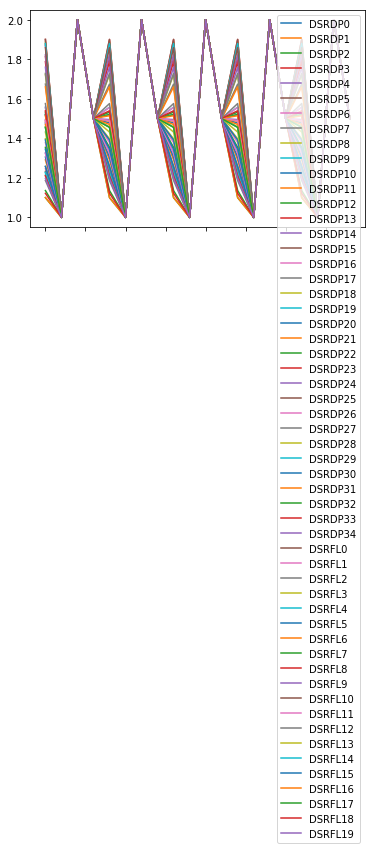

In [41]:
df_final.T.plot.line()

In [42]:
df_final

,actual0,lower0,upper0,best_estimate0,actual1,lower1,upper1,best_estimate1,actual2,lower2,upper2,best_estimate2,actual3,lower3,upper3,best_estimate3,actual4,lower4,upper4,best_estimate4
DSRDP0,1.520303,1,2,1.5,1.520303,1.0,2.0,1.5,1.520303,1.0,2.0,1.5,1.520303,1.0,2.0,1.5,1.520303,1.0,2.0,1.5
DSRDP1,1.290710,1,2,1.5,1.290710,1.0,2.0,1.5,1.290710,1.0,2.0,1.5,1.290710,1.0,2.0,1.5,1.290710,1.0,2.0,1.5
DSRDP2,1.520151,1,2,1.5,1.520151,1.0,2.0,1.5,1.520151,1.0,2.0,1.5,1.520151,1.0,2.0,1.5,1.520151,1.0,2.0,1.5
DSRDP3,1.900000,1,2,1.5,1.900000,1.0,2.0,1.5,1.900000,1.0,2.0,1.5,1.900000,1.0,2.0,1.5,1.900000,1.0,2.0,1.5
DSRDP4,1.494693,1,2,1.5,1.494693,1.0,2.0,1.5,1.494693,1.0,2.0,1.5,1.494693,1.0,2.0,1.5,1.494693,1.0,2.0,1.5
DSRDP5,1.877726,1,2,1.5,1.877726,1.0,2.0,1.5,1.877726,1.0,2.0,1.5,1.877726,1.0,2.0,1.5,1.877726,1.0,2.0,1.5
DSRDP6,1.378691,1,2,1.5,1.378691,1.0,2.0,1.5,1.378691,1.0,2.0,1.5,1.378691,1.0,2.0,1.5,1.378691,1.0,2.0,1.5
DSRDP7,1.674263,1,2,1.5,1.674263,1.0,2.0,1.5,1.674263,1.0,2.0,1.5,1.674263,1.0,2.0,1.5,1.674263,1.0,2.0,1.5
DSRDP8,1.397518,1,2,1.5,1.397518,1.0,2.0,1.5,1.397518,1.0,2.0,1.5,1.397518,1.0,2.0,1.5,1.397518,1.0,2.0,1.5
DSRDP9,1.224829,1,2,1.5,1.224829,1.0,2.0,1.5,1.224829,1.0,2.0,1.5,1.224829,1.0,2.0,1.5,1.224829,1.0,2.0,1.5


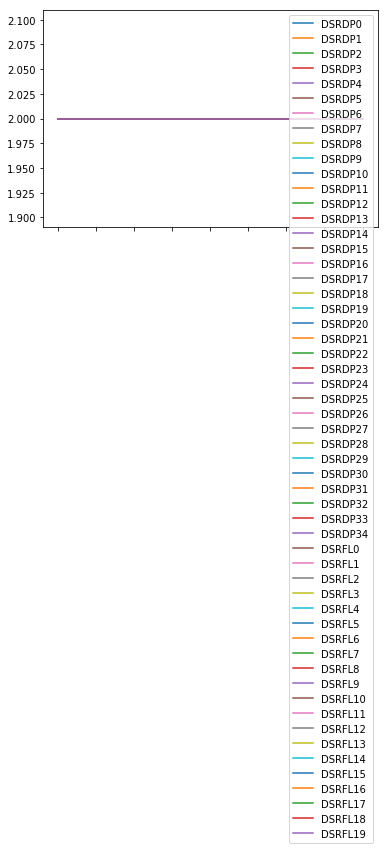

In [43]:
pd.DataFrame({"name{}".format(i):df['upper'] for i,df in enumerate(testdfs)}).T.plot()

In [257]:
global_dfs_var_unc_data['p0n0']

,actual,lower,upper,best_estimate
DSRDP0,1.015003,1.008658,1.598299,1.303479
DSRDP1,1.858495,1.106396,1.914770,1.510583
DSRDP2,1.341087,1.310102,1.567980,1.439041
DSRDP3,1.448467,1.265519,1.675949,1.470734
DSRDP4,1.615594,1.094348,1.818576,1.456462
DSRDP5,1.890072,1.614069,1.929471,1.771770
DSRDP6,1.324616,1.179957,1.677272,1.428614
DSRDP7,1.121350,1.012851,1.694784,1.353817
DSRDP8,1.938678,1.409590,1.945943,1.677767
DSRDP9,1.915348,1.278802,1.943758,1.611280


In [229]:
label

'p0n0p1n1p2n4p3n13p4n40'

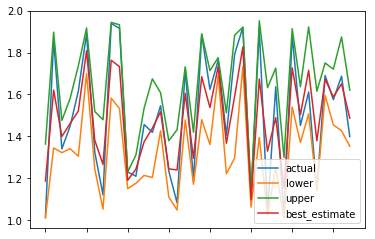

In [59]:
global_dfs_var_unc_data['p0n0p1n2'].plot()#kind='bar')

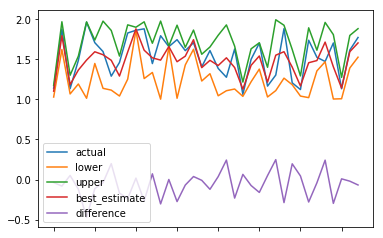

In [124]:
df_test.plot()

#### test functions 

# check for size of dictionary and its items

In [34]:
from __future__ import print_function
from sys import getsizeof, stderr
from itertools import chain
from collections import deque
try:
    from reprlib import repr
except ImportError:
    pass

def total_size(o, handlers={}, verbose=False):
    """ Returns the approximate memory footprint an object and all of its contents.

    Automatically finds the contents of the following builtin containers and
    their subclasses:  tuple, list, deque, dict, set and frozenset.
    To search other containers, add handlers to iterate over their contents:

        handlers = {SomeContainerClass: iter,
                    OtherContainerClass: OtherContainerClass.get_elements}

    """
    dict_handler = lambda d: chain.from_iterable(d.items())
    all_handlers = {tuple: iter,
                    list: iter,
                    deque: iter,
                    dict: dict_handler,
                    set: iter,
                    frozenset: iter,
                   }
    all_handlers.update(handlers)     # user handlers take precedence
    seen = set()                      # track which object id's have already been seen
    default_size = getsizeof(0)       # estimate sizeof object without __sizeof__

    def sizeof(o):
        if id(o) in seen:       # do not double count the same object
            return 0
        seen.add(id(o))
        s = getsizeof(o, default_size)

        if verbose:
            print(s, type(o), repr(o), file=stderr)

        for typ, handler in all_handlers.items():
            if isinstance(o, typ):
                s += sum(map(sizeof, handler(o)))
                break
        return s

    return sizeof(o)


# ##### Example call #####

# if __name__ == '__main__':
#     d = dict(a=1, b=2, c=3, d=[4,5,6,7], e='a string of chars')
#     print(total_size(d, verbose=True))

In [47]:
print(total_size(global_dfs_var_unc_data, verbose=True))

4704 <class 'dict'> {'p0n0':            ac...      1.524229, 'p0n0p1n1':            ac...      1.487009, 'p0n0p1n1p2n4':            ac...      1.442561, 'p0n0p1n1p2n4p3n13':            ac...      1.414339, ...}
53 <class 'str'> 'p0n0'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.524229
57 <class 'str'> 'p0n0p1n1'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.487009
57 <class 'str'> 'p0n0p1n2'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.487009
57 <class 'str'> 'p0n0p1n3'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.487009
61 <class 'str'> 'p0n0p1n1p2n4'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.442561
61 <class 'str'> 'p0n0p1n1p2n5'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.442561
61 <class 'str'> 'p0n0p1n1p2n6'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.442561
61 <class 'str'> 'p0n0p1n2p2n7'
4220 <class 'pandas.core.frame.Data

472179


 <class 'pandas.core.frame.DataFrame'>            ac...      1.403051
73 <class 'str'> 'p0n0p1n3p2n12p3n39p4n107'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.403051
73 <class 'str'> 'p0n0p1n3p2n12p3n39p4n108'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.403051


In [35]:
print(total_size(global_dfs_var_unc_data, verbose=True))

18528 <class 'dict'> {'p0n0':            ac...      1.622947, 'p0n0p1n1':            ac...      1.607807, 'p0n0p1n1p2n6':            ac...      1.588514, 'p0n0p1n1p2n6p3n28':            ac...      1.574864, ...}
53 <class 'str'> 'p0n0'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.622947
57 <class 'str'> 'p0n0p1n1'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.607807
57 <class 'str'> 'p0n0p1n2'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.607807
57 <class 'str'> 'p0n0p1n3'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.607807
57 <class 'str'> 'p0n0p1n4'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.607807
57 <class 'str'> 'p0n0p1n5'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.607807
61 <class 'str'> 'p0n0p1n1p2n6'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.588514
61 <class 'str'> 'p0n0p1n1p2n7'
5564 <class 'pandas.core.frame.DataFrame'>

5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.574864
67 <class 'str'> 'p0n0p1n3p2n18p3n87'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.574864
67 <class 'str'> 'p0n0p1n3p2n18p3n88'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.574864
67 <class 'str'> 'p0n0p1n4p2n19p3n89'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.574864
67 <class 'str'> 'p0n0p1n4p2n19p3n90'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.574864
67 <class 'str'> 'p0n0p1n4p2n19p3n91'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.574864
67 <class 'str'> 'p0n0p1n4p2n19p3n92'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.574864
67 <class 'str'> 'p0n0p1n4p2n19p3n93'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.574864
67 <class 'str'> 'p0n0p1n4p2n19p3n94'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.574864
67 <class 'str'> 'p0n0p1n4p2n2

5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
72 <class 'str'> 'p0n0p1n1p2n8p3n40p4n178'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
72 <class 'str'> 'p0n0p1n1p2n8p3n40p4n179'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
72 <class 'str'> 'p0n0p1n1p2n8p3n40p4n180'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
72 <class 'str'> 'p0n0p1n1p2n8p3n41p4n181'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
72 <class 'str'> 'p0n0p1n1p2n8p3n41p4n182'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
72 <class 'str'> 'p0n0p1n1p2n8p3n41p4n183'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
72 <class 'str'> 'p0n0p1n1p2n8p3n41p4n184'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
72 <class 'str'> 'p0n0p1n1p2n8p3n41p4n185'
5564 <class 'pandas.core.frame.DataFrame'>            ac...     

5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n14p3n65p4n271'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n14p3n65p4n272'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n14p3n65p4n273'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n14p3n65p4n274'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n14p3n65p4n275'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n14p3n65p4n276'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n14p3n66p4n277'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n14p3n66p4n278'
5564 <class 'pandas.core.frame.DataFrame'>            ac

5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n18p3n86p4n374'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n18p3n86p4n375'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n18p3n87p4n376'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n18p3n87p4n377'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n18p3n87p4n378'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n18p3n87p4n379'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n18p3n88p4n380'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n18p3n88p4n381'
5564 <class 'pandas.core.frame.DataFrame'>            ac

5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n4p2n22p3n107p4n469'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n4p2n22p3n108p4n470'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n4p2n22p3n108p4n471'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n4p2n22p3n108p4n472'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n4p2n22p3n108p4n473'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n4p2n23p3n109p4n474'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n4p2n23p3n109p4n475'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n4p2n23p3n109p4n476'
5564 <class 'pandas.core.frame.DataFrame'>      

5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n4p2n24p3n121p4n540'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n25p3n122p4n541'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n25p3n122p4n542'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n25p3n122p4n543'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n25p3n123p4n544'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n25p3n123p4n545'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n25p3n123p4n546'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n25p3n124p4n547'
5564 <class 'pandas.core.frame.DataFrame'>      

3382939


 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n26p3n130p4n568'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n27p3n131p4n569'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n27p3n131p4n570'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n27p3n131p4n571'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n27p3n131p4n572'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n27p3n131p4n573'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n27p3n132p4n574'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n27p3n132p4n575'
5564 <class 'pandas.core.frame.DataFrame'>          